### Algorithms comparison - Group 4 Marwin Prenner
This notebook is supposed to show a concise comparison of different ML algorithms, trained on the combined bank data, as well as the separate datasets of the three different banks.
This notebook uses the preprocessed versions of all datasets.

Structure (subject to change, keep up to date):
* Import of libraries and datasets
* MLP - combined data
* MLP - separate datasets
* MLP - Plots
* XGBoost - combined data
* XGBoost - separate datasets
* XGBoost - Plots
* Random Forest - combined data
* Random Forest - separate datasets
* Random Forest - Plots
* Random Forest - combined data - optimized with random search

Since my colleagues Matthias and Merna took over the task to experiment with MLP and XGBoost, I focused on optimizing the Random Forest model. Therefore the other models are not looked at as in depth as the Random Forest in this notebook.

Edit: It seems that Merna did not continue the work with MLP.

#### Import libraries and data

In [16]:
# import libraries
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [17]:
# load all data
df_bank_a = pd.read_csv("data\BankA_preprocessed.csv")
df_bank_b = pd.read_csv("data\BankB_preprocessed.csv")
df_bank_c = pd.read_csv("data\BankC_preprocessed.csv")
df_all = pd.concat([df_bank_a, df_bank_b, df_bank_c])

In [18]:
#info on data
print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
Index: 799999 entries, 0 to 170594
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   age             799999 non-null  int64 
 1   workclass       799999 non-null  object
 2   education       799999 non-null  object
 3   marital-status  799999 non-null  object
 4   occupation      799999 non-null  object
 5   relationship    799999 non-null  object
 6   hours-per-week  799999 non-null  int64 
 7   native-country  799999 non-null  object
 8   income          799999 non-null  int64 
 9   capital-diff    799999 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 67.1+ MB
None


In [19]:
"""# drop institute column
df_all = df.drop(["institute"], axis=1)
df_bank_a = df[df["institute"] == "Bank A"]
df_bank_b = df[df["institute"] == "Bank B"]
df_bank_c = df[df["institute"] == "Bank C"]
"""

# encode the categorical variables
df_all = pd.get_dummies(df_all, drop_first=True)
df_bank_a = pd.get_dummies(df_bank_a, drop_first=True)
df_bank_b = pd.get_dummies(df_bank_b, drop_first=True)
df_bank_c = pd.get_dummies(df_bank_c, drop_first=True)

In [20]:
# check out the latest version of the dataset
df_all.head()

,age,hours-per-week,income,capital-diff,workclass_Local-gov,workclass_Not-working,workclass_Private,workclass_Self-emp-inc,workclass_Self-emp-not-inc,workclass_State-gov,...,occupation_medium,occupation_unknown,relationship_Other-relative,relationship_Own-child,relationship_Parent,relationship_Unmarried,native-country_Europe,native-country_North-America,native-country_South-America,native-country_Unknown
0,39,50,1,7298,False,False,True,False,False,False,...,False,False,False,False,True,False,False,True,False,False
1,42,55,1,0,False,False,True,False,False,False,...,True,False,False,False,True,False,False,True,False,False
2,56,15,0,0,False,False,False,False,False,False,...,False,True,True,False,False,False,False,True,False,False
3,34,40,0,0,False,False,True,False,False,False,...,True,False,False,False,True,False,False,True,False,False
4,66,40,1,15024,False,False,False,True,False,False,...,True,False,False,False,True,False,False,True,False,False


In [21]:
# create random sample and split
def create_sample_and_split(df, sample_size=0.05, test_size=0.2, random_state=42):
    """
    Nimmt eine zufällige Stichprobe aus dem gegebenen DataFrame,
    teilt sie in Features (X) und Zielvariable (y) und dann
    in Trainings- und Testsets.
    
    :param df: DataFrame, aus dem die Stichprobe genommen wird.
    :param sample_size: Anteil der Stichprobe (zwischen 0 und 1).
    :param test_size: Anteil des Testsets an der Stichprobe (zwischen 0 und 1).
    :param random_state: Seed für die Zufälligkeitskontrolle.
    :return: Trainings- und Testsets (X_train, X_test, y_train, y_test).
    """
    # Zufällige Stichprobenauswahl
    df_sample = df.sample(frac=sample_size, random_state=random_state)

    # Teilen Sie die Stichprobe in Features und Zielvariable
    X_sample = df_sample.drop('income', axis=1)
    y_sample = df_sample['income']

    # Teilen Sie die Stichprobe in Trainings- und Testsets
    X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

# Anwenden der Funktion auf das globale Dataset und jedes Bank-Dataset
X_train_global, X_test_global, y_train_global, y_test_global = create_sample_and_split(df_all)
X_train_bank_a, X_test_bank_a, y_train_bank_a, y_test_bank_a = create_sample_and_split(df_bank_a)
X_train_bank_b, X_test_bank_b, y_train_bank_b, y_test_bank_b = create_sample_and_split(df_bank_b)
X_train_bank_c, X_test_bank_c, y_train_bank_c, y_test_bank_c = create_sample_and_split(df_bank_c)


In [22]:
# balance the global dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_global_smote, y_train_global_smote = smote.fit_resample(X_train_global, y_train_global)

# balance the single bank datasets using SMOTE
X_train_bank_a_smote, y_train_bank_a_smote = smote.fit_resample(X_train_bank_a, y_train_bank_a)
X_train_bank_b_smote, y_train_bank_b_smote = smote.fit_resample(X_train_bank_b, y_train_bank_b)
X_train_bank_c_smote, y_train_bank_c_smote = smote.fit_resample(X_train_bank_c, y_train_bank_c)


#### MLP - combined data


In [23]:
# train a multi-layer perceptron on the global dataset
mlp_global_base = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, activation='relu', solver='adam', random_state=42)
mlp_global_base.fit(X_train_global, y_train_global)

# assess the performance on the global test set
y_pred_mlp_global_base = mlp_global_base.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score
acc_mlp_global_base = accuracy_score(y_test_global, y_pred_mlp_global_base)
prec_mlp_global_base = precision_score(y_test_global, y_pred_mlp_global_base)
rec_mlp_global_base = recall_score(y_test_global, y_pred_mlp_global_base)
f1_mlp_global_base = f1_score(y_test_global, y_pred_mlp_global_base)

In [24]:
# print the results
print("Accuracy:", acc_mlp_global_base)
print("Precision:", prec_mlp_global_base)
print("Recall:", rec_mlp_global_base)
print("F1 score:", f1_mlp_global_base)

Accuracy: 0.85025
Precision: 0.7699775952203136
Recall: 0.536699635606455
F1 score: 0.6325153374233129


In [25]:
# train a multi-layer perceptron on the global dataset with SMOTE
mlp_global_smote = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, activation='relu', solver='adam', random_state=42)
mlp_global_smote.fit(X_train_global_smote, y_train_global_smote)

# assess the performance on the global test set
y_pred_mlp_global_smote = mlp_global_smote.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score
acc_mlp_global_smote = accuracy_score(y_test_global, y_pred_mlp_global_smote)
prec_mlp_global_smote = precision_score(y_test_global, y_pred_mlp_global_smote)
rec_mlp_global_smote = recall_score(y_test_global, y_pred_mlp_global_smote)
f1_mlp_global_smote = f1_score(y_test_global, y_pred_mlp_global_smote)

In [26]:
# print the results
print("Accuracy:", acc_mlp_global_smote)
print("Precision:", prec_mlp_global_smote)
print("Recall:", rec_mlp_global_smote)
print("F1 score:", f1_mlp_global_smote)

Accuracy: 0.821625
Precision: 0.5991967871485944
Recall: 0.7766788131181677
F1 score: 0.6764905917025618


#### MLP - separate datasets


In [27]:
# train multi-layer perceptrons on the single bank datasets
mlp_bank_a_base = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, activation='relu', solver='sgd', random_state=42)
mlp_bank_a_base.fit(X_train_bank_a, y_train_bank_a)

mlp_bank_b_base = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, activation='relu', solver='sgd', random_state=42)
mlp_bank_b_base.fit(X_train_bank_b, y_train_bank_b)

mlp_bank_c_base = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, activation='relu', solver='sgd', random_state=42)
mlp_bank_c_base.fit(X_train_bank_c, y_train_bank_c)

MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, random_state=42,
              solver='sgd')

In [28]:
# assess the performance on the single bank test sets
y_pred_mlp_bank_a_base = mlp_bank_a_base.predict(X_test_bank_a)
y_pred_mlp_bank_b_base = mlp_bank_b_base.predict(X_test_bank_b)
y_pred_mlp_bank_c_base = mlp_bank_c_base.predict(X_test_bank_c)

# assess the performance on the global test set
y_pred_mlp_bank_a_global = mlp_bank_a_base.predict(X_test_global)
y_pred_mlp_bank_b_global = mlp_bank_b_base.predict(X_test_global)
y_pred_mlp_bank_c_global = mlp_bank_c_base.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score for the single bank test sets
acc_mlp_bank_a_base = accuracy_score(y_test_bank_a, y_pred_mlp_bank_a_base)
prec_mlp_bank_a_base = precision_score(y_test_bank_a, y_pred_mlp_bank_a_base)
rec_mlp_bank_a_base = recall_score(y_test_bank_a, y_pred_mlp_bank_a_base)
f1_mlp_bank_a_base = f1_score(y_test_bank_a, y_pred_mlp_bank_a_base)

acc_mlp_bank_b_base = accuracy_score(y_test_bank_b, y_pred_mlp_bank_b_base)
prec_mlp_bank_b_base = precision_score(y_test_bank_b, y_pred_mlp_bank_b_base)
rec_mlp_bank_b_base = recall_score(y_test_bank_b, y_pred_mlp_bank_b_base)
f1_mlp_bank_b_base = f1_score(y_test_bank_b, y_pred_mlp_bank_b_base)

acc_mlp_bank_c_base = accuracy_score(y_test_bank_c, y_pred_mlp_bank_c_base)
prec_mlp_bank_c_base = precision_score(y_test_bank_c, y_pred_mlp_bank_c_base)
rec_mlp_bank_c_base = recall_score(y_test_bank_c, y_pred_mlp_bank_c_base)
f1_mlp_bank_c_base = f1_score(y_test_bank_c, y_pred_mlp_bank_c_base)

# find out accuracy, precision, recall, and F1 score for the global test set

acc_mlp_bank_a_global = accuracy_score(y_test_global, y_pred_mlp_bank_a_global)
prec_mlp_bank_a_global = precision_score(y_test_global, y_pred_mlp_bank_a_global)
rec_mlp_bank_a_global = recall_score(y_test_global, y_pred_mlp_bank_a_global)
f1_mlp_bank_a_global = f1_score(y_test_global, y_pred_mlp_bank_a_global)

acc_mlp_bank_b_global = accuracy_score(y_test_global, y_pred_mlp_bank_b_global)
prec_mlp_bank_b_global = precision_score(y_test_global, y_pred_mlp_bank_b_global)
rec_mlp_bank_b_global = recall_score(y_test_global, y_pred_mlp_bank_b_global)
f1_mlp_bank_b_global = f1_score(y_test_global, y_pred_mlp_bank_b_global)

acc_mlp_bank_c_global = accuracy_score(y_test_global, y_pred_mlp_bank_c_global)
prec_mlp_bank_c_global = precision_score(y_test_global, y_pred_mlp_bank_c_global)
rec_mlp_bank_c_global = recall_score(y_test_global, y_pred_mlp_bank_c_global)
f1_mlp_bank_c_global = f1_score(y_test_global, y_pred_mlp_bank_c_global)

In [29]:
# train multi-layer perceptrons on the single bank datasets with SMOTE
mlp_bank_a_smote = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, activation='relu', solver='sgd', random_state=42)
mlp_bank_a_smote.fit(X_train_bank_a_smote, y_train_bank_a_smote)

mlp_bank_b_smote = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, activation='relu', solver='sgd', random_state=42)
mlp_bank_b_smote.fit(X_train_bank_b_smote, y_train_bank_b_smote)

mlp_bank_c_smote = MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, activation='relu', solver='sgd', random_state=42)
mlp_bank_c_smote.fit(X_train_bank_c_smote, y_train_bank_c_smote)


MLPClassifier(hidden_layer_sizes=(50, 30), max_iter=300, random_state=42,
              solver='sgd')

In [30]:
# assess the performance on the single bank test sets with SMOTE
y_pred_mlp_bank_a_smote = mlp_bank_a_smote.predict(X_test_bank_a)
y_pred_mlp_bank_b_smote = mlp_bank_b_smote.predict(X_test_bank_b)
y_pred_mlp_bank_c_smote = mlp_bank_c_smote.predict(X_test_bank_c)

# assess the performance on the global test set with SMOTE
y_pred_mlp_bank_a_global_smote = mlp_bank_a_smote.predict(X_test_global)
y_pred_mlp_bank_b_global_smote = mlp_bank_b_smote.predict(X_test_global)
y_pred_mlp_bank_c_global_smote = mlp_bank_c_smote.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score for the single bank test sets with SMOTE
acc_mlp_bank_a_smote = accuracy_score(y_test_bank_a, y_pred_mlp_bank_a_smote)
prec_mlp_bank_a_smote = precision_score(y_test_bank_a, y_pred_mlp_bank_a_smote)
rec_mlp_bank_a_smote = recall_score(y_test_bank_a, y_pred_mlp_bank_a_smote)
f1_mlp_bank_a_smote = f1_score(y_test_bank_a, y_pred_mlp_bank_a_smote)

acc_mlp_bank_b_smote = accuracy_score(y_test_bank_b, y_pred_mlp_bank_b_smote)
prec_mlp_bank_b_smote = precision_score(y_test_bank_b, y_pred_mlp_bank_b_smote)
rec_mlp_bank_b_smote = recall_score(y_test_bank_b, y_pred_mlp_bank_b_smote)
f1_mlp_bank_b_smote = f1_score(y_test_bank_b, y_pred_mlp_bank_b_smote)

acc_mlp_bank_c_smote = accuracy_score(y_test_bank_c, y_pred_mlp_bank_c_smote)
prec_mlp_bank_c_smote = precision_score(y_test_bank_c, y_pred_mlp_bank_c_smote)
rec_mlp_bank_c_smote = recall_score(y_test_bank_c, y_pred_mlp_bank_c_smote)
f1_mlp_bank_c_smote = f1_score(y_test_bank_c, y_pred_mlp_bank_c_smote)

# find out accuracy, precision, recall, and F1 score for the global test set with SMOTE
acc_mlp_bank_a_global_smote = accuracy_score(y_test_global, y_pred_mlp_bank_a_global_smote)
prec_mlp_bank_a_global_smote = precision_score(y_test_global, y_pred_mlp_bank_a_global_smote)
rec_mlp_bank_a_global_smote = recall_score(y_test_global, y_pred_mlp_bank_a_global_smote)
f1_mlp_bank_a_global_smote = f1_score(y_test_global, y_pred_mlp_bank_a_global_smote)

acc_mlp_bank_b_global_smote = accuracy_score(y_test_global, y_pred_mlp_bank_b_global_smote)
prec_mlp_bank_b_global_smote = precision_score(y_test_global, y_pred_mlp_bank_b_global_smote)
rec_mlp_bank_b_global_smote = recall_score(y_test_global, y_pred_mlp_bank_b_global_smote)
f1_mlp_bank_b_global_smote = f1_score(y_test_global, y_pred_mlp_bank_b_global_smote)

acc_mlp_bank_c_global_smote = accuracy_score(y_test_global, y_pred_mlp_bank_c_global_smote)
prec_mlp_bank_c_global_smote = precision_score(y_test_global, y_pred_mlp_bank_c_global_smote)
rec_mlp_bank_c_global_smote = recall_score(y_test_global, y_pred_mlp_bank_c_global_smote)
f1_mlp_bank_c_global_smote = f1_score(y_test_global, y_pred_mlp_bank_c_global_smote)

c:\Users\marwi\anaconda3\envs\fml\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marwi\anaconda3\envs\fml\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marwi\anaconda3\envs\fml\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\marwi\anaconda3\envs\fml\Lib\site-packages\sklearn\metrics\_classification.py:1471

After having moved the preprocessing to the external notebook a problem with the "local" MLP models that use the smote optimized data occured. Since my colleague Merna has been so kind as to take over the task of trying to fix the MLP, I dod not pursue this problem further. However for the sake of completeness I decided to keep this attempt in the notebook

#### MLP - Plots

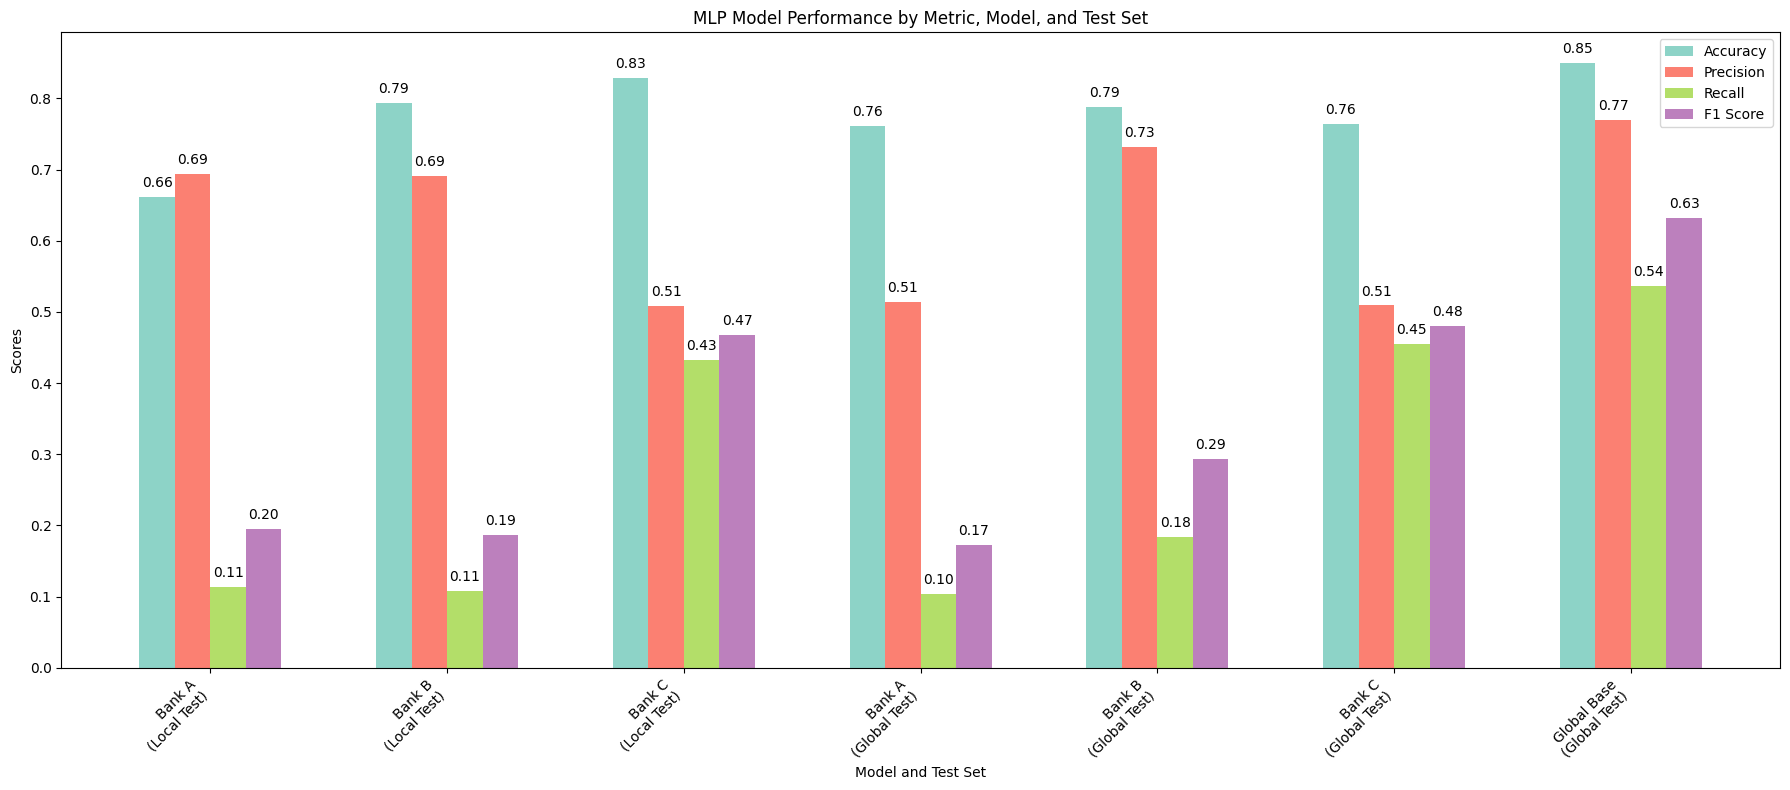

In [31]:
# compare all base results
# Daten für den Plot vorbereiten
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
groups = ['Bank A\n(Local Test)', 'Bank B\n(Local Test)', 'Bank C\n(Local Test)', 
          'Bank A\n(Global Test)', 'Bank B\n(Global Test)', 'Bank C\n(Global Test)', 
          'Global Base\n(Global Test)']

values = np.array([
    [acc_mlp_bank_a_base, prec_mlp_bank_a_base, rec_mlp_bank_a_base, f1_mlp_bank_a_base],
    [acc_mlp_bank_b_base, prec_mlp_bank_b_base, rec_mlp_bank_b_base, f1_mlp_bank_b_base],
    [acc_mlp_bank_c_base, prec_mlp_bank_c_base, rec_mlp_bank_c_base, f1_mlp_bank_c_base],
    [acc_mlp_bank_a_global, prec_mlp_bank_a_global, rec_mlp_bank_a_global, f1_mlp_bank_a_global],
    [acc_mlp_bank_b_global, prec_mlp_bank_b_global, rec_mlp_bank_b_global, f1_mlp_bank_b_global],
    [acc_mlp_bank_c_global, prec_mlp_bank_c_global, rec_mlp_bank_c_global, f1_mlp_bank_c_global],
    [acc_mlp_global_base, prec_mlp_global_base, rec_mlp_global_base, f1_mlp_global_base]
])

n_groups = len(groups)
n_metrics = len(metrics)
index = np.arange(n_groups)  # Die Gruppen-Positionen auf der x-Achse
bar_width = 0.15  # Die Breite der Balken

fig, ax = plt.subplots(figsize=(18, 8))

# Erstelle Balken für jede Metrik
for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, values[:, i], bar_width, label=metric, color=plt.cm.Set3(i / float(n_metrics)))

# Hinzufügen von Text für Labels, Titel und benutzerdefinierte x-Achsen-Tick-Labels usw.
ax.set_xlabel('Model and Test Set')
ax.set_ylabel('Scores')
ax.set_title('MLP Model Performance by Metric, Model, and Test Set')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

# Hinzufügen von Werte-Labels über jedem Balken
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        ax.annotate(
            '{:.2f}'.format(y_value), 
            (x_value, y_value), 
            xytext=(0, space), 
            textcoords='offset points', 
            ha='center', 
            va=va)

add_value_labels(ax)

plt.tight_layout()
plt.show()


Trying to solve the new problem with MLP I decided to take a closer look at the data within the following two cells. Since they are very computational intensive and are not necessary for the further steps of the notebook they have been commented out.

In [32]:
"""
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Funktion zur Visualisierung der Daten mit t-SNE
def visualize_with_tsne(X, y, title='t-SNE visualization'):
    X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)
    plt.figure(figsize=(10, 6))
    for class_value in np.unique(y):
        plt.scatter(X_embedded[y == class_value, 0], X_embedded[y == class_value, 1], label=str(class_value), alpha=0.6)
    plt.title(title)
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.legend()
    plt.show()

# Visualisierung für die einzelnen Bankdatensätze vor und nach SMOTE
bank_datasets = {
    'Bank A Original': (X_train_bank_a, y_train_bank_a),
    'Bank A SMOTE': (X_train_bank_a_smote, y_train_bank_a_smote),
    'Bank B Original': (X_train_bank_b, y_train_bank_b),
    'Bank B SMOTE': (X_train_bank_b_smote, y_train_bank_b_smote),
    'Bank C Original': (X_train_bank_c, y_train_bank_c),
    'Bank C SMOTE': (X_train_bank_c_smote, y_train_bank_c_smote)
}

for title, (X, y) in bank_datasets.items():
    visualize_with_tsne(X, y, title=f'{title} - t-SNE visualization')

# Visualisierung für den globalen Datensatz vor und nach SMOTE
visualize_with_tsne(X_train_global, y_train_global, title='Global Dataset Original - t-SNE visualization')
visualize_with_tsne(X_train_global_smote, y_train_global_smote, title='Global Dataset SMOTE - t-SNE visualization')
"""

"\nfrom sklearn.manifold import TSNE\nimport matplotlib.pyplot as plt\n\n# Funktion zur Visualisierung der Daten mit t-SNE\ndef visualize_with_tsne(X, y, title='t-SNE visualization'):\n    X_embedded = TSNE(n_components=2, random_state=42).fit_transform(X)\n    plt.figure(figsize=(10, 6))\n    for class_value in np.unique(y):\n        plt.scatter(X_embedded[y == class_value, 0], X_embedded[y == class_value, 1], label=str(class_value), alpha=0.6)\n    plt.title(title)\n    plt.xlabel('t-SNE feature 1')\n    plt.ylabel('t-SNE feature 2')\n    plt.legend()\n    plt.show()\n\n# Visualisierung für die einzelnen Bankdatensätze vor und nach SMOTE\nbank_datasets = {\n    'Bank A Original': (X_train_bank_a, y_train_bank_a),\n    'Bank A SMOTE': (X_train_bank_a_smote, y_train_bank_a_smote),\n    'Bank B Original': (X_train_bank_b, y_train_bank_b),\n    'Bank B SMOTE': (X_train_bank_b_smote, y_train_bank_b_smote),\n    'Bank C Original': (X_train_bank_c, y_train_bank_c),\n    'Bank C SMOTE': (X_t

In [33]:
"""from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Funktion zur Visualisierung der Daten mit PCA
def visualize_with_pca(X, y, title='PCA visualization'):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(10, 6))
    for class_value in np.unique(y):
        plt.scatter(X_pca[y == class_value, 0], X_pca[y == class_value, 1], label=str(class_value), alpha=0.6)
    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.show()

# Visualisierung für die einzelnen Bankdatensätze vor und nach SMOTE
bank_datasets = {
    'Bank A Original': (X_train_bank_a, y_train_bank_a),
    'Bank A SMOTE': (X_train_bank_a_smote, y_train_bank_a_smote),
    'Bank B Original': (X_train_bank_b, y_train_bank_b),
    'Bank B SMOTE': (X_train_bank_b_smote, y_train_bank_b_smote),
    'Bank C Original': (X_train_bank_c, y_train_bank_c),
    'Bank C SMOTE': (X_train_bank_c_smote, y_train_bank_c_smote)
}

for title, (X, y) in bank_datasets.items():
    visualize_with_pca(X, y, title=f'{title} - PCA visualization')

# Visualisierung für den globalen Datensatz vor und nach SMOTE
visualize_with_pca(X_train_global, y_train_global, title='Global Dataset Original - PCA visualization')
visualize_with_pca(X_train_global_smote, y_train_global_smote, title='Global Dataset SMOTE - PCA visualization')
"""


"from sklearn.decomposition import PCA\nimport matplotlib.pyplot as plt\n\n# Funktion zur Visualisierung der Daten mit PCA\ndef visualize_with_pca(X, y, title='PCA visualization'):\n    pca = PCA(n_components=2)\n    X_pca = pca.fit_transform(X)\n    plt.figure(figsize=(10, 6))\n    for class_value in np.unique(y):\n        plt.scatter(X_pca[y == class_value, 0], X_pca[y == class_value, 1], label=str(class_value), alpha=0.6)\n    plt.title(title)\n    plt.xlabel('Principal Component 1')\n    plt.ylabel('Principal Component 2')\n    plt.legend()\n    plt.show()\n\n# Visualisierung für die einzelnen Bankdatensätze vor und nach SMOTE\nbank_datasets = {\n    'Bank A Original': (X_train_bank_a, y_train_bank_a),\n    'Bank A SMOTE': (X_train_bank_a_smote, y_train_bank_a_smote),\n    'Bank B Original': (X_train_bank_b, y_train_bank_b),\n    'Bank B SMOTE': (X_train_bank_b_smote, y_train_bank_b_smote),\n    'Bank C Original': (X_train_bank_c, y_train_bank_c),\n    'Bank C SMOTE': (X_train_bank

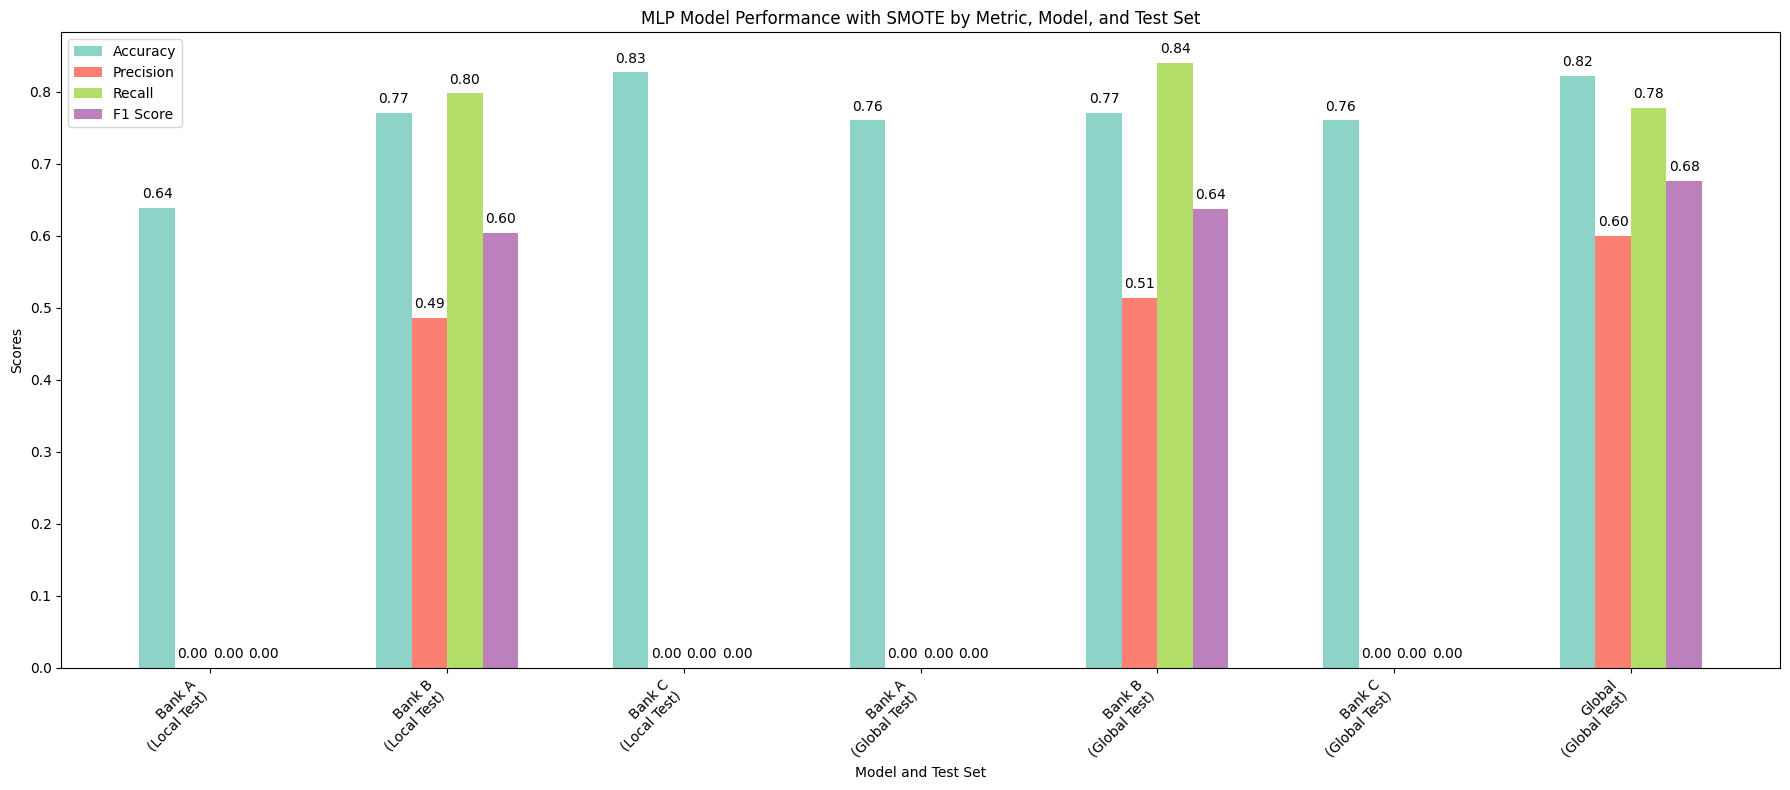

In [34]:
# compare all SMOTE results
# Daten für den Plot vorbereiten
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
groups = ['Bank A\n(Local Test)', 'Bank B\n(Local Test)', 'Bank C\n(Local Test)', 
          'Bank A\n(Global Test)', 'Bank B\n(Global Test)', 'Bank C\n(Global Test)', 
          'Global\n(Global Test)']

values_smote = np.array([
    [acc_mlp_bank_a_smote, prec_mlp_bank_a_smote, rec_mlp_bank_a_smote, f1_mlp_bank_a_smote],
    [acc_mlp_bank_b_smote, prec_mlp_bank_b_smote, rec_mlp_bank_b_smote, f1_mlp_bank_b_smote],
    [acc_mlp_bank_c_smote, prec_mlp_bank_c_smote, rec_mlp_bank_c_smote, f1_mlp_bank_c_smote],
    [acc_mlp_bank_a_global_smote, prec_mlp_bank_a_global_smote, rec_mlp_bank_a_global_smote, f1_mlp_bank_a_global_smote],
    [acc_mlp_bank_b_global_smote, prec_mlp_bank_b_global_smote, rec_mlp_bank_b_global_smote, f1_mlp_bank_b_global_smote],
    [acc_mlp_bank_c_global_smote, prec_mlp_bank_c_global_smote, rec_mlp_bank_c_global_smote, f1_mlp_bank_c_global_smote],
    [acc_mlp_global_smote, prec_mlp_global_smote, rec_mlp_global_smote, f1_mlp_global_smote]
])

n_groups = len(groups)
n_metrics = len(metrics)
index = np.arange(n_groups)  # Die Gruppen-Positionen auf der x-Achse
bar_width = 0.15  # Die Breite der Balken

fig, ax = plt.subplots(figsize=(18, 8))

# Erstelle Balken für jede Metrik
for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, values_smote[:, i], bar_width, label=metric, color=plt.cm.Set3(i / float(n_metrics)))

# Hinzufügen von Text für Labels, Titel und benutzerdefinierte x-Achsen-Tick-Labels usw.
ax.set_xlabel('Model and Test Set')
ax.set_ylabel('Scores')
ax.set_title('MLP Model Performance with SMOTE by Metric, Model, and Test Set')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

# Hinzufügen von Werte-Labels über jedem Balken
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        ax.annotate(
            '{:.2f}'.format(y_value), 
            (x_value, y_value), 
            xytext=(0, space), 
            textcoords='offset points', 
            ha='center', 
            va=va)

add_value_labels(ax)

plt.tight_layout()
plt.show()


#### XGBoost - combined data

In [35]:
# train XGBoost on the global dataset without SMOTE
xgb_global_base = XGBClassifier(random_state=42)
xgb_global_base.fit(X_train_global, y_train_global)

# assess the performance on the global test set
y_pred_xgb_global_base = xgb_global_base.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score
acc_xgb_global_base = accuracy_score(y_test_global, y_pred_xgb_global_base)
prec_xgb_global_base = precision_score(y_test_global, y_pred_xgb_global_base)
rec_xgb_global_base = recall_score(y_test_global, y_pred_xgb_global_base)
f1_xgb_global_base = f1_score(y_test_global, y_pred_xgb_global_base)

In [36]:
# train XGBoost on the global dataset with SMOTE
xgb_global_smote = XGBClassifier(random_state=42)
xgb_global_smote.fit(X_train_global_smote, y_train_global_smote)

# assess the performance on the global test set
y_pred_xgb_global_smote = xgb_global_smote.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score
acc_xgb_global_smote = accuracy_score(y_test_global, y_pred_xgb_global_smote)
prec_xgb_global_smote = precision_score(y_test_global, y_pred_xgb_global_smote)
rec_xgb_global_smote = recall_score(y_test_global, y_pred_xgb_global_smote)
f1_xgb_global_smote = f1_score(y_test_global, y_pred_xgb_global_smote)

#### XGBoost - separate datasets


In [37]:
# train XGBoost on the single bank datasets
xgb_bank_a_base = XGBClassifier(random_state=42)
xgb_bank_a_base.fit(X_train_bank_a, y_train_bank_a)

xgb_bank_b_base = XGBClassifier(random_state=42)
xgb_bank_b_base.fit(X_train_bank_b, y_train_bank_b)

xgb_bank_c_base = XGBClassifier(random_state=42)
xgb_bank_c_base.fit(X_train_bank_c, y_train_bank_c)

# assess the performance on the single bank test sets
y_pred_xgb_bank_a_base = xgb_bank_a_base.predict(X_test_bank_a)
y_pred_xgb_bank_b_base = xgb_bank_b_base.predict(X_test_bank_b)
y_pred_xgb_bank_c_base = xgb_bank_c_base.predict(X_test_bank_c)

# assess the performance on the global test set
y_pred_xgb_bank_a_global = xgb_bank_a_base.predict(X_test_global)
y_pred_xgb_bank_b_global = xgb_bank_b_base.predict(X_test_global)
y_pred_xgb_bank_c_global = xgb_bank_c_base.predict(X_test_global)

In [38]:
# find out accuracy, precision, recall, and F1 score for the single bank test sets
acc_xgb_bank_a_base = accuracy_score(y_test_bank_a, y_pred_xgb_bank_a_base)
prec_xgb_bank_a_base = precision_score(y_test_bank_a, y_pred_xgb_bank_a_base)
rec_xgb_bank_a_base = recall_score(y_test_bank_a, y_pred_xgb_bank_a_base)
f1_xgb_bank_a_base = f1_score(y_test_bank_a, y_pred_xgb_bank_a_base)

acc_xgb_bank_b_base = accuracy_score(y_test_bank_b, y_pred_xgb_bank_b_base)
prec_xgb_bank_b_base = precision_score(y_test_bank_b, y_pred_xgb_bank_b_base)
rec_xgb_bank_b_base = recall_score(y_test_bank_b, y_pred_xgb_bank_b_base)
f1_xgb_bank_b_base = f1_score(y_test_bank_b, y_pred_xgb_bank_b_base)

acc_xgb_bank_c_base = accuracy_score(y_test_bank_c, y_pred_xgb_bank_c_base)
prec_xgb_bank_c_base = precision_score(y_test_bank_c, y_pred_xgb_bank_c_base)
rec_xgb_bank_c_base = recall_score(y_test_bank_c, y_pred_xgb_bank_c_base)
f1_xgb_bank_c_base = f1_score(y_test_bank_c, y_pred_xgb_bank_c_base)

# find out accuracy, precision, recall, and F1 score for the global test set
acc_xgb_bank_a_global = accuracy_score(y_test_global, y_pred_xgb_bank_a_global)
prec_xgb_bank_a_global = precision_score(y_test_global, y_pred_xgb_bank_a_global)
rec_xgb_bank_a_global = recall_score(y_test_global, y_pred_xgb_bank_a_global)
f1_xgb_bank_a_global = f1_score(y_test_global, y_pred_xgb_bank_a_global)

acc_xgb_bank_b_global = accuracy_score(y_test_global, y_pred_xgb_bank_b_global)
prec_xgb_bank_b_global = precision_score(y_test_global, y_pred_xgb_bank_b_global)
rec_xgb_bank_b_global = recall_score(y_test_global, y_pred_xgb_bank_b_global)
f1_xgb_bank_b_global = f1_score(y_test_global, y_pred_xgb_bank_b_global)

acc_xgb_bank_c_global = accuracy_score(y_test_global, y_pred_xgb_bank_c_global)
prec_xgb_bank_c_global = precision_score(y_test_global, y_pred_xgb_bank_c_global)
rec_xgb_bank_c_global = recall_score(y_test_global, y_pred_xgb_bank_c_global)
f1_xgb_bank_c_global = f1_score(y_test_global, y_pred_xgb_bank_c_global)

In [39]:
# train XGBoost on the single bank datasets with SMOTE
xgb_bank_a_smote = XGBClassifier(random_state=42)
xgb_bank_a_smote.fit(X_train_bank_a_smote, y_train_bank_a_smote)

xgb_bank_b_smote = XGBClassifier(random_state=42)
xgb_bank_b_smote.fit(X_train_bank_b_smote, y_train_bank_b_smote)

xgb_bank_c_smote = XGBClassifier(random_state=42)
xgb_bank_c_smote.fit(X_train_bank_c_smote, y_train_bank_c_smote)

# assess the performance on the single bank test sets with SMOTE
y_pred_xgb_bank_a_smote = xgb_bank_a_smote.predict(X_test_bank_a)
y_pred_xgb_bank_b_smote = xgb_bank_b_smote.predict(X_test_bank_b)
y_pred_xgb_bank_c_smote = xgb_bank_c_smote.predict(X_test_bank_c)

# assess the performance on the global test set with SMOTE
y_pred_xgb_bank_a_global_smote = xgb_bank_a_smote.predict(X_test_global)
y_pred_xgb_bank_b_global_smote = xgb_bank_b_smote.predict(X_test_global)
y_pred_xgb_bank_c_global_smote = xgb_bank_c_smote.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score for the single bank test sets with SMOTE
acc_xgb_bank_a_smote = accuracy_score(y_test_bank_a, y_pred_xgb_bank_a_smote)
prec_xgb_bank_a_smote = precision_score(y_test_bank_a, y_pred_xgb_bank_a_smote)
rec_xgb_bank_a_smote = recall_score(y_test_bank_a, y_pred_xgb_bank_a_smote)
f1_xgb_bank_a_smote = f1_score(y_test_bank_a, y_pred_xgb_bank_a_smote)

acc_xgb_bank_b_smote = accuracy_score(y_test_bank_b, y_pred_xgb_bank_b_smote)
prec_xgb_bank_b_smote = precision_score(y_test_bank_b, y_pred_xgb_bank_b_smote)
rec_xgb_bank_b_smote = recall_score(y_test_bank_b, y_pred_xgb_bank_b_smote)
f1_xgb_bank_b_smote = f1_score(y_test_bank_b, y_pred_xgb_bank_b_smote)

acc_xgb_bank_c_smote = accuracy_score(y_test_bank_c, y_pred_xgb_bank_c_smote)
prec_xgb_bank_c_smote = precision_score(y_test_bank_c, y_pred_xgb_bank_c_smote)
rec_xgb_bank_c_smote = recall_score(y_test_bank_c, y_pred_xgb_bank_c_smote)
f1_xgb_bank_c_smote = f1_score(y_test_bank_c, y_pred_xgb_bank_c_smote)

# find out accuracy, precision, recall, and F1 score for the global test set with SMOTE
acc_xgb_bank_a_global_smote = accuracy_score(y_test_global, y_pred_xgb_bank_a_global_smote)
prec_xgb_bank_a_global_smote = precision_score(y_test_global, y_pred_xgb_bank_a_global_smote)
rec_xgb_bank_a_global_smote = recall_score(y_test_global, y_pred_xgb_bank_a_global_smote)
f1_xgb_bank_a_global_smote = f1_score(y_test_global, y_pred_xgb_bank_a_global_smote)

acc_xgb_bank_b_global_smote = accuracy_score(y_test_global, y_pred_xgb_bank_b_global_smote)
prec_xgb_bank_b_global_smote = precision_score(y_test_global, y_pred_xgb_bank_b_global_smote)
rec_xgb_bank_b_global_smote = recall_score(y_test_global, y_pred_xgb_bank_b_global_smote)
f1_xgb_bank_b_global_smote = f1_score(y_test_global, y_pred_xgb_bank_b_global_smote)

acc_xgb_bank_c_global_smote = accuracy_score(y_test_global, y_pred_xgb_bank_c_global_smote)
prec_xgb_bank_c_global_smote = precision_score(y_test_global, y_pred_xgb_bank_c_global_smote)
rec_xgb_bank_c_global_smote = recall_score(y_test_global, y_pred_xgb_bank_c_global_smote)
f1_xgb_bank_c_global_smote = f1_score(y_test_global, y_pred_xgb_bank_c_global_smote)

#### XGB - Plots

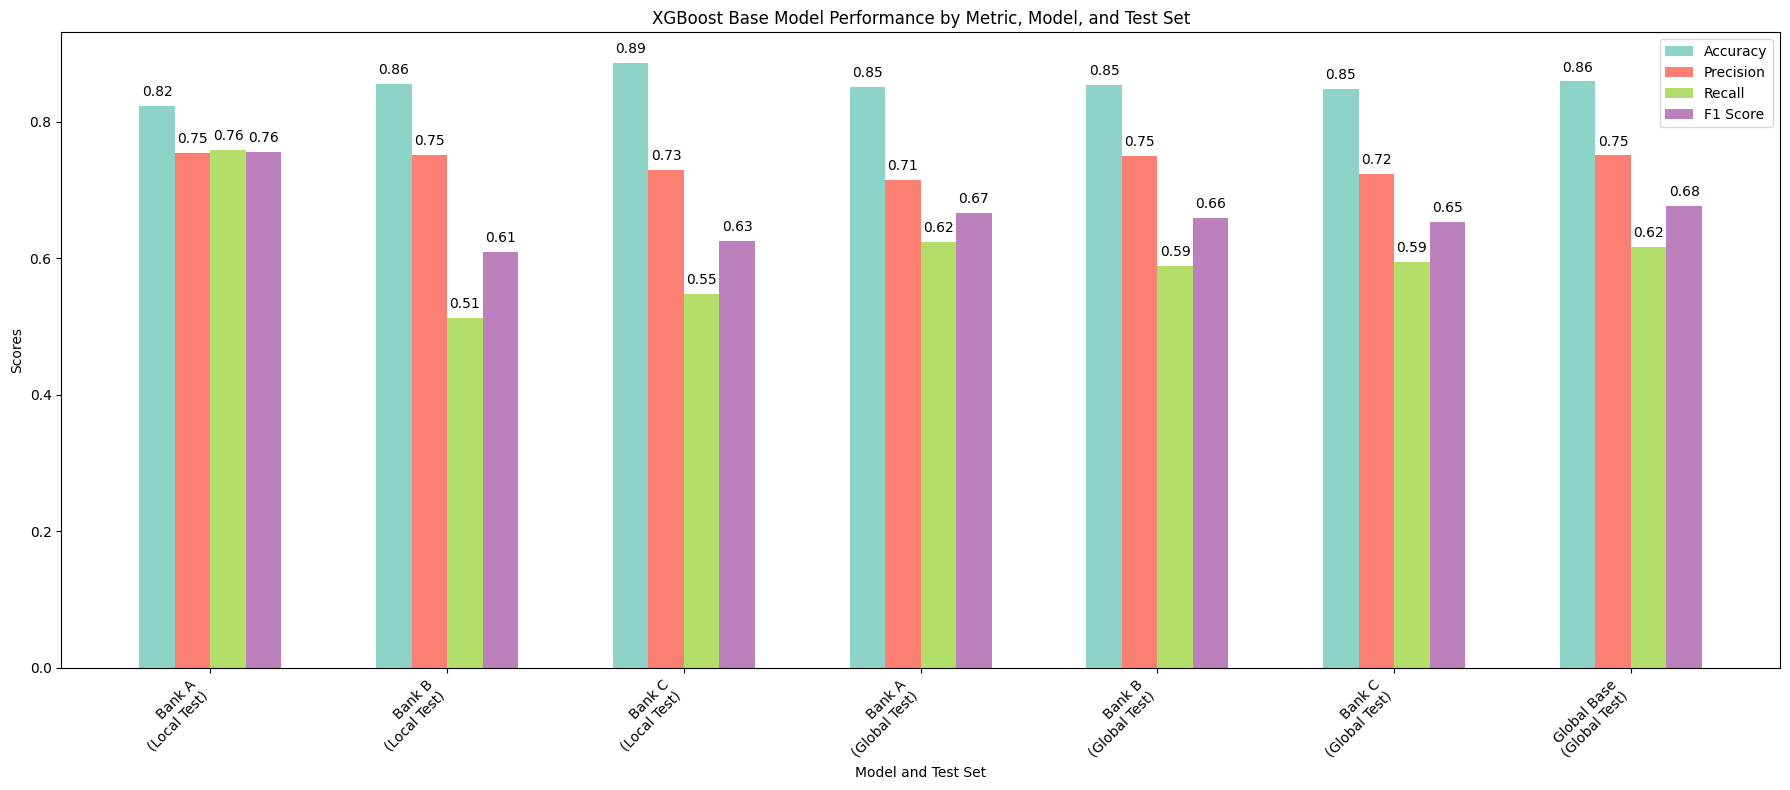

In [40]:
# compare all base results
# Daten für den Plot vorbereiten
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
groups = ['Bank A\n(Local Test)', 'Bank B\n(Local Test)', 'Bank C\n(Local Test)', 
          'Bank A\n(Global Test)', 'Bank B\n(Global Test)', 'Bank C\n(Global Test)', 
          'Global Base\n(Global Test)']

values_xgb_base = np.array([
    [acc_xgb_bank_a_base, prec_xgb_bank_a_base, rec_xgb_bank_a_base, f1_xgb_bank_a_base],
    [acc_xgb_bank_b_base, prec_xgb_bank_b_base, rec_xgb_bank_b_base, f1_xgb_bank_b_base],
    [acc_xgb_bank_c_base, prec_xgb_bank_c_base, rec_xgb_bank_c_base, f1_xgb_bank_c_base],
    [acc_xgb_bank_a_global, prec_xgb_bank_a_global, rec_xgb_bank_a_global, f1_xgb_bank_a_global],
    [acc_xgb_bank_b_global, prec_xgb_bank_b_global, rec_xgb_bank_b_global, f1_xgb_bank_b_global],
    [acc_xgb_bank_c_global, prec_xgb_bank_c_global, rec_xgb_bank_c_global, f1_xgb_bank_c_global],
    [acc_xgb_global_base, prec_xgb_global_base, rec_xgb_global_base, f1_xgb_global_base]
])

n_groups = len(groups)
n_metrics = len(metrics)
index = np.arange(n_groups)  # Die Gruppen-Positionen auf der x-Achse
bar_width = 0.15  # Die Breite der Balken

fig, ax = plt.subplots(figsize=(18, 8))

# Erstelle Balken für jede Metrik
for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, values_xgb_base[:, i], bar_width, label=metric, color=plt.cm.Set3(i / float(n_metrics)))

# Hinzufügen von Text für Labels, Titel und benutzerdefinierte x-Achsen-Tick-Labels usw.
ax.set_xlabel('Model and Test Set')
ax.set_ylabel('Scores')
ax.set_title('XGBoost Base Model Performance by Metric, Model, and Test Set')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

# Hinzufügen von Werte-Labels über jedem Balken
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        ax.annotate(
            '{:.2f}'.format(y_value), 
            (x_value, y_value), 
            xytext=(0, space), 
            textcoords='offset points', 
            ha='center', 
            va=va)

add_value_labels(ax)

plt.tight_layout()
plt.show()


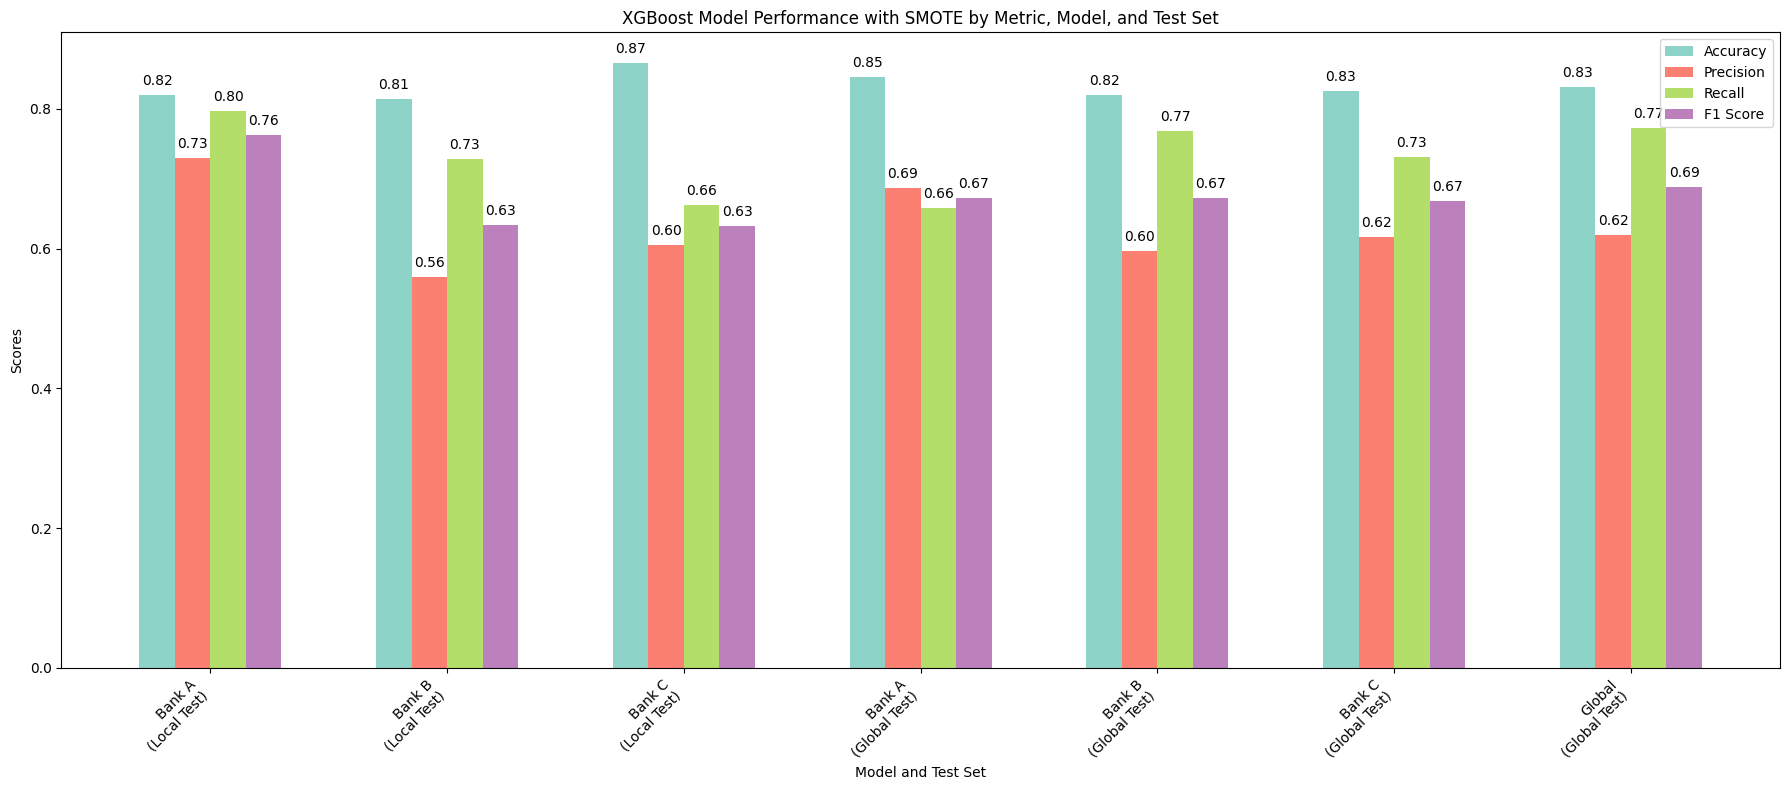

In [41]:
# compare all SMOTE results
# Daten für den Plot vorbereiten
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
groups = ['Bank A\n(Local Test)', 'Bank B\n(Local Test)', 'Bank C\n(Local Test)', 
          'Bank A\n(Global Test)', 'Bank B\n(Global Test)', 'Bank C\n(Global Test)', 
          'Global\n(Global Test)']

values_xgb_smote = np.array([
    [acc_xgb_bank_a_smote, prec_xgb_bank_a_smote, rec_xgb_bank_a_smote, f1_xgb_bank_a_smote],
    [acc_xgb_bank_b_smote, prec_xgb_bank_b_smote, rec_xgb_bank_b_smote, f1_xgb_bank_b_smote],
    [acc_xgb_bank_c_smote, prec_xgb_bank_c_smote, rec_xgb_bank_c_smote, f1_xgb_bank_c_smote],
    [acc_xgb_bank_a_global_smote, prec_xgb_bank_a_global_smote, rec_xgb_bank_a_global_smote, f1_xgb_bank_a_global_smote],
    [acc_xgb_bank_b_global_smote, prec_xgb_bank_b_global_smote, rec_xgb_bank_b_global_smote, f1_xgb_bank_b_global_smote],
    [acc_xgb_bank_c_global_smote, prec_xgb_bank_c_global_smote, rec_xgb_bank_c_global_smote, f1_xgb_bank_c_global_smote],
    [acc_xgb_global_smote, prec_xgb_global_smote, rec_xgb_global_smote, f1_xgb_global_smote]
])

n_groups = len(groups)
n_metrics = len(metrics)
index = np.arange(n_groups)  # Die Gruppen-Positionen auf der x-Achse
bar_width = 0.15  # Die Breite der Balken

fig, ax = plt.subplots(figsize=(18, 8))

# Erstelle Balken für jede Metrik
for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, values_xgb_smote[:, i], bar_width, label=metric, color=plt.cm.Set3(i / float(n_metrics)))

# Hinzufügen von Text für Labels, Titel und benutzerdefinierte x-Achsen-Tick-Labels usw.
ax.set_xlabel('Model and Test Set')
ax.set_ylabel('Scores')
ax.set_title('XGBoost Model Performance with SMOTE by Metric, Model, and Test Set')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

# Hinzufügen von Werte-Labels über jedem Balken
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        ax.annotate(
            '{:.2f}'.format(y_value), 
            (x_value, y_value), 
            xytext=(0, space), 
            textcoords='offset points', 
            ha='center', 
            va=va)

add_value_labels(ax)

plt.tight_layout()
plt.show()


#### Random Forest - combined data


In [42]:
# for all Random Forests, that are not base we will use the same parameters
optimal_rf_params = {
    "n_estimators": 300,
    "max_depth": 25,
    "sampling_strategy": 1.0  # for SMOTE
}


In [43]:
# train a random forest on the global dataset without SMOTE
rf_global_base = RandomForestClassifier(random_state=42)
rf_global_base.fit(X_train_global, y_train_global)

# assess the performance on the global test set
y_pred_rf_global_base = rf_global_base.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score
acc_rf_global_base = accuracy_score(y_test_global, y_pred_rf_global_base)
prec_rf_global_base = precision_score(y_test_global, y_pred_rf_global_base)
rec_rf_global_base = recall_score(y_test_global, y_pred_rf_global_base)
f1_rf_global_base = f1_score(y_test_global, y_pred_rf_global_base)

# train a random forest on the global dataset with SMOTE
rf_global_smote = RandomForestClassifier(n_estimators=optimal_rf_params["n_estimators"],
    max_depth=optimal_rf_params["max_depth"], random_state=42)
rf_global_smote.fit(X_train_global_smote, y_train_global_smote)

# assess the performance on the global test set
y_pred_rf_global_smote = rf_global_smote.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score
acc_rf_global_smote = accuracy_score(y_test_global, y_pred_rf_global_smote)
prec_rf_global_smote = precision_score(y_test_global, y_pred_rf_global_smote)
rec_rf_global_smote = recall_score(y_test_global, y_pred_rf_global_smote)
f1_rf_global_smote = f1_score(y_test_global, y_pred_rf_global_smote)

#### Random Forest - separate datasets

In [44]:
# train a random forest on the single bank datasets
rf_bank_a_base = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf_bank_a_base.fit(X_train_bank_a, y_train_bank_a)

rf_bank_b_base = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf_bank_b_base.fit(X_train_bank_b, y_train_bank_b)

rf_bank_c_base = RandomForestClassifier(n_estimators=200, max_depth=None, random_state=42)
rf_bank_c_base.fit(X_train_bank_c, y_train_bank_c)

# assess the performance on the single bank test sets
y_pred_rf_bank_a_base = rf_bank_a_base.predict(X_test_bank_a)
y_pred_rf_bank_b_base = rf_bank_b_base.predict(X_test_bank_b)
y_pred_rf_bank_c_base = rf_bank_c_base.predict(X_test_bank_c)

# assess the performance on the global test set
y_pred_rf_bank_a_global = rf_bank_a_base.predict(X_test_global)
y_pred_rf_bank_b_global = rf_bank_b_base.predict(X_test_global)
y_pred_rf_bank_c_global = rf_bank_c_base.predict(X_test_global)


In [45]:
# find out accuracy, precision, recall, and F1 score for the single bank test sets
acc_rf_bank_a_base = accuracy_score(y_test_bank_a, y_pred_rf_bank_a_base)
prec_rf_bank_a_base = precision_score(y_test_bank_a, y_pred_rf_bank_a_base)
rec_rf_bank_a_base = recall_score(y_test_bank_a, y_pred_rf_bank_a_base)
f1_rf_bank_a_base = f1_score(y_test_bank_a, y_pred_rf_bank_a_base)

acc_rf_bank_b_base = accuracy_score(y_test_bank_b, y_pred_rf_bank_b_base)
prec_rf_bank_b_base = precision_score(y_test_bank_b, y_pred_rf_bank_b_base)
rec_rf_bank_b_base = recall_score(y_test_bank_b, y_pred_rf_bank_b_base)
f1_rf_bank_b_base = f1_score(y_test_bank_b, y_pred_rf_bank_b_base)

acc_rf_bank_c_base = accuracy_score(y_test_bank_c, y_pred_rf_bank_c_base)
prec_rf_bank_c_base = precision_score(y_test_bank_c, y_pred_rf_bank_c_base)
rec_rf_bank_c_base = recall_score(y_test_bank_c, y_pred_rf_bank_c_base)
f1_rf_bank_c_base = f1_score(y_test_bank_c, y_pred_rf_bank_c_base)

# find out accuracy, precision, recall, and F1 score for the global test set
acc_rf_bank_a_global = accuracy_score(y_test_global, y_pred_rf_bank_a_global)
prec_rf_bank_a_global = precision_score(y_test_global, y_pred_rf_bank_a_global)
rec_rf_bank_a_global = recall_score(y_test_global, y_pred_rf_bank_a_global)
f1_rf_bank_a_global = f1_score(y_test_global, y_pred_rf_bank_a_global)

acc_rf_bank_b_global = accuracy_score(y_test_global, y_pred_rf_bank_b_global)
prec_rf_bank_b_global = precision_score(y_test_global, y_pred_rf_bank_b_global)
rec_rf_bank_b_global = recall_score(y_test_global, y_pred_rf_bank_b_global)
f1_rf_bank_b_global = f1_score(y_test_global, y_pred_rf_bank_b_global)

acc_rf_bank_c_global = accuracy_score(y_test_global, y_pred_rf_bank_c_global)
prec_rf_bank_c_global = precision_score(y_test_global, y_pred_rf_bank_c_global)
rec_rf_bank_c_global = recall_score(y_test_global, y_pred_rf_bank_c_global)
f1_rf_bank_c_global = f1_score(y_test_global, y_pred_rf_bank_c_global)

In [46]:
# train a random forest on the single bank datasets with SMOTE
rf_bank_a_smote = RandomForestClassifier(n_estimators=optimal_rf_params["n_estimators"],
    max_depth=optimal_rf_params["max_depth"], random_state=42)
rf_bank_a_smote.fit(X_train_bank_a_smote, y_train_bank_a_smote)

rf_bank_b_smote = RandomForestClassifier(n_estimators=optimal_rf_params["n_estimators"],
    max_depth=optimal_rf_params["max_depth"], random_state=42)
rf_bank_b_smote.fit(X_train_bank_b_smote, y_train_bank_b_smote)

rf_bank_c_smote = RandomForestClassifier(n_estimators=optimal_rf_params["n_estimators"],
    max_depth=optimal_rf_params["max_depth"], random_state=42)
rf_bank_c_smote.fit(X_train_bank_c_smote, y_train_bank_c_smote)

# assess the performance on the single bank test sets with SMOTE
y_pred_rf_bank_a_smote = rf_bank_a_smote.predict(X_test_bank_a)
y_pred_rf_bank_b_smote = rf_bank_b_smote.predict(X_test_bank_b)
y_pred_rf_bank_c_smote = rf_bank_c_smote.predict(X_test_bank_c)

# assess the performance on the global test set with SMOTE
y_pred_rf_bank_a_global_smote = rf_bank_a_smote.predict(X_test_global)
y_pred_rf_bank_b_global_smote = rf_bank_b_smote.predict(X_test_global)
y_pred_rf_bank_c_global_smote = rf_bank_c_smote.predict(X_test_global)

# find out accuracy, precision, recall, and F1 score for the single bank test sets with SMOTE
acc_rf_bank_a_smote = accuracy_score(y_test_bank_a, y_pred_rf_bank_a_smote)
prec_rf_bank_a_smote = precision_score(y_test_bank_a, y_pred_rf_bank_a_smote)
rec_rf_bank_a_smote = recall_score(y_test_bank_a, y_pred_rf_bank_a_smote)
f1_rf_bank_a_smote = f1_score(y_test_bank_a, y_pred_rf_bank_a_smote)

acc_rf_bank_b_smote = accuracy_score(y_test_bank_b, y_pred_rf_bank_b_smote)
prec_rf_bank_b_smote = precision_score(y_test_bank_b, y_pred_rf_bank_b_smote)
rec_rf_bank_b_smote = recall_score(y_test_bank_b, y_pred_rf_bank_b_smote)
f1_rf_bank_b_smote = f1_score(y_test_bank_b, y_pred_rf_bank_b_smote)

acc_rf_bank_c_smote = accuracy_score(y_test_bank_c, y_pred_rf_bank_c_smote)
prec_rf_bank_c_smote = precision_score(y_test_bank_c, y_pred_rf_bank_c_smote)
rec_rf_bank_c_smote = recall_score(y_test_bank_c, y_pred_rf_bank_c_smote)
f1_rf_bank_c_smote = f1_score(y_test_bank_c, y_pred_rf_bank_c_smote)

# find out accuracy, precision, recall, and F1 score for the global test set with SMOTE
acc_rf_bank_a_global_smote = accuracy_score(y_test_global, y_pred_rf_bank_a_global_smote)
prec_rf_bank_a_global_smote = precision_score(y_test_global, y_pred_rf_bank_a_global_smote)
rec_rf_bank_a_global_smote = recall_score(y_test_global, y_pred_rf_bank_a_global_smote)
f1_rf_bank_a_global_smote = f1_score(y_test_global, y_pred_rf_bank_a_global_smote)

acc_rf_bank_b_global_smote = accuracy_score(y_test_global, y_pred_rf_bank_b_global_smote)
prec_rf_bank_b_global_smote = precision_score(y_test_global, y_pred_rf_bank_b_global_smote)
rec_rf_bank_b_global_smote = recall_score(y_test_global, y_pred_rf_bank_b_global_smote)
f1_rf_bank_b_global_smote = f1_score(y_test_global, y_pred_rf_bank_b_global_smote)

acc_rf_bank_c_global_smote = accuracy_score(y_test_global, y_pred_rf_bank_c_global_smote)
prec_rf_bank_c_global_smote = precision_score(y_test_global, y_pred_rf_bank_c_global_smote)
rec_rf_bank_c_global_smote = recall_score(y_test_global, y_pred_rf_bank_c_global_smote)
f1_rf_bank_c_global_smote = f1_score(y_test_global, y_pred_rf_bank_c_global_smote)

#### Random Forest - Plots

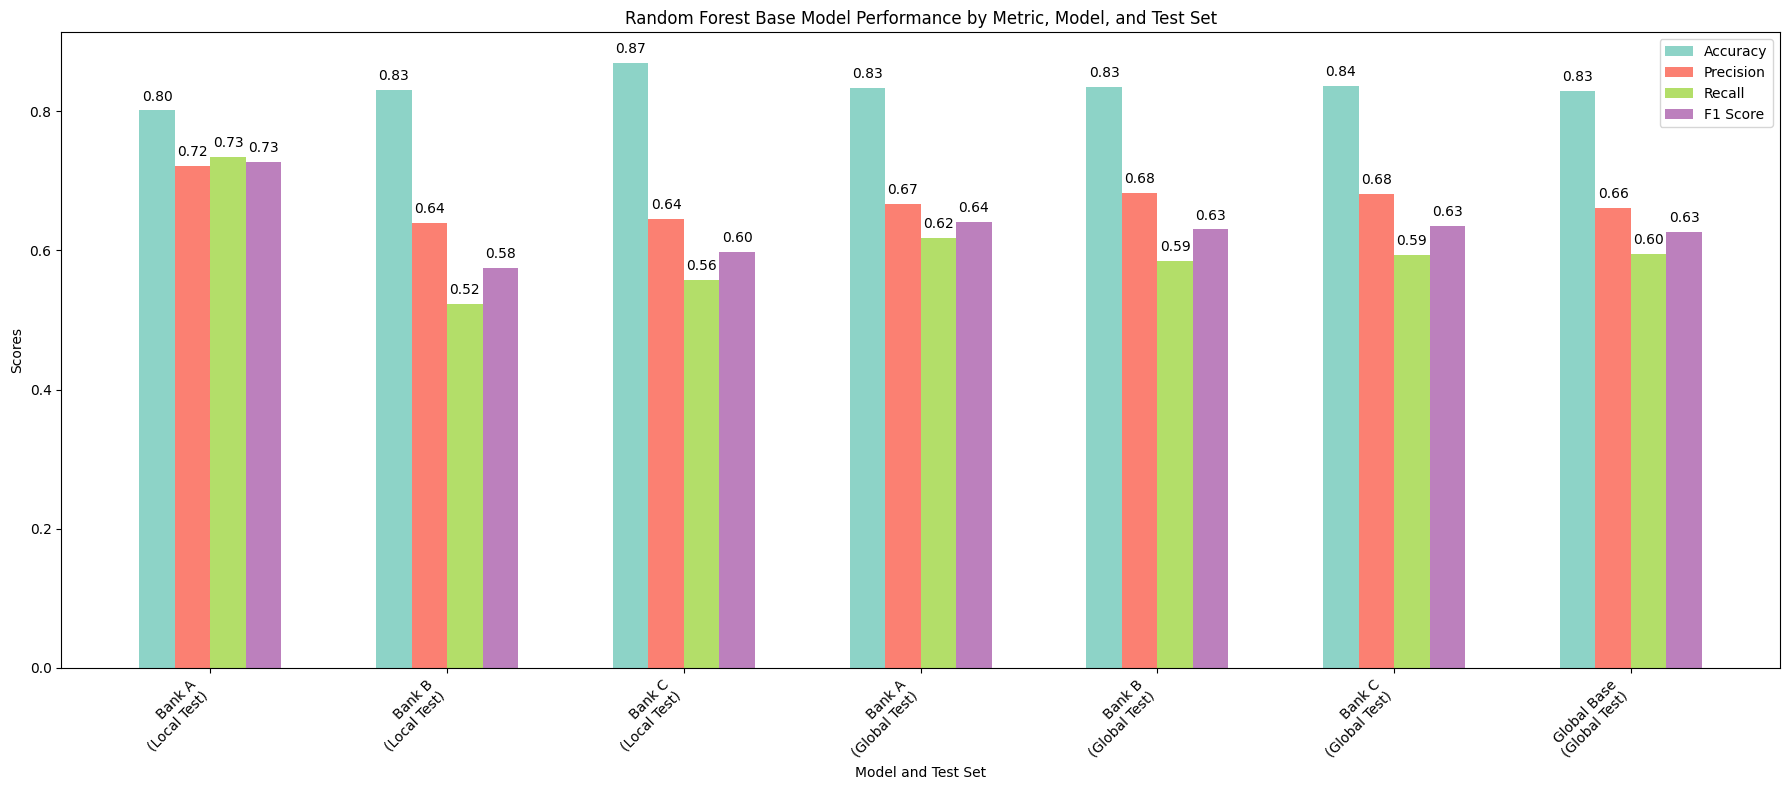

In [47]:
# Daten für den Plot vorbereiten
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
groups = ['Bank A\n(Local Test)', 'Bank B\n(Local Test)', 'Bank C\n(Local Test)', 
          'Bank A\n(Global Test)', 'Bank B\n(Global Test)', 'Bank C\n(Global Test)', 
          'Global Base\n(Global Test)']

values_rf_base = np.array([
    [acc_rf_bank_a_base, prec_rf_bank_a_base, rec_rf_bank_a_base, f1_rf_bank_a_base],
    [acc_rf_bank_b_base, prec_rf_bank_b_base, rec_rf_bank_b_base, f1_rf_bank_b_base],
    [acc_rf_bank_c_base, prec_rf_bank_c_base, rec_rf_bank_c_base, f1_rf_bank_c_base],
    [acc_rf_bank_a_global, prec_rf_bank_a_global, rec_rf_bank_a_global, f1_rf_bank_a_global],
    [acc_rf_bank_b_global, prec_rf_bank_b_global, rec_rf_bank_b_global, f1_rf_bank_b_global],
    [acc_rf_bank_c_global, prec_rf_bank_c_global, rec_rf_bank_c_global, f1_rf_bank_c_global],
    [acc_rf_global_base, prec_rf_global_base, rec_rf_global_base, f1_rf_global_base]
])

n_groups = len(groups)
n_metrics = len(metrics)
index = np.arange(n_groups)  # Die Gruppen-Positionen auf der x-Achse
bar_width = 0.15  # Die Breite der Balken

fig, ax = plt.subplots(figsize=(18, 8))

# Erstelle Balken für jede Metrik
for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, values_rf_base[:, i], bar_width, label=metric, color=plt.cm.Set3(i / float(n_metrics)))

# Hinzufügen von Text für Labels, Titel und benutzerdefinierte x-Achsen-Tick-Labels usw.
ax.set_xlabel('Model and Test Set')
ax.set_ylabel('Scores')
ax.set_title('Random Forest Base Model Performance by Metric, Model, and Test Set')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

# Hinzufügen von Werte-Labels über jedem Balken
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        ax.annotate(
            '{:.2f}'.format(y_value), 
            (x_value, y_value), 
            xytext=(0, space), 
            textcoords='offset points', 
            ha='center', 
            va=va)

add_value_labels(ax)

plt.tight_layout()
plt.show()


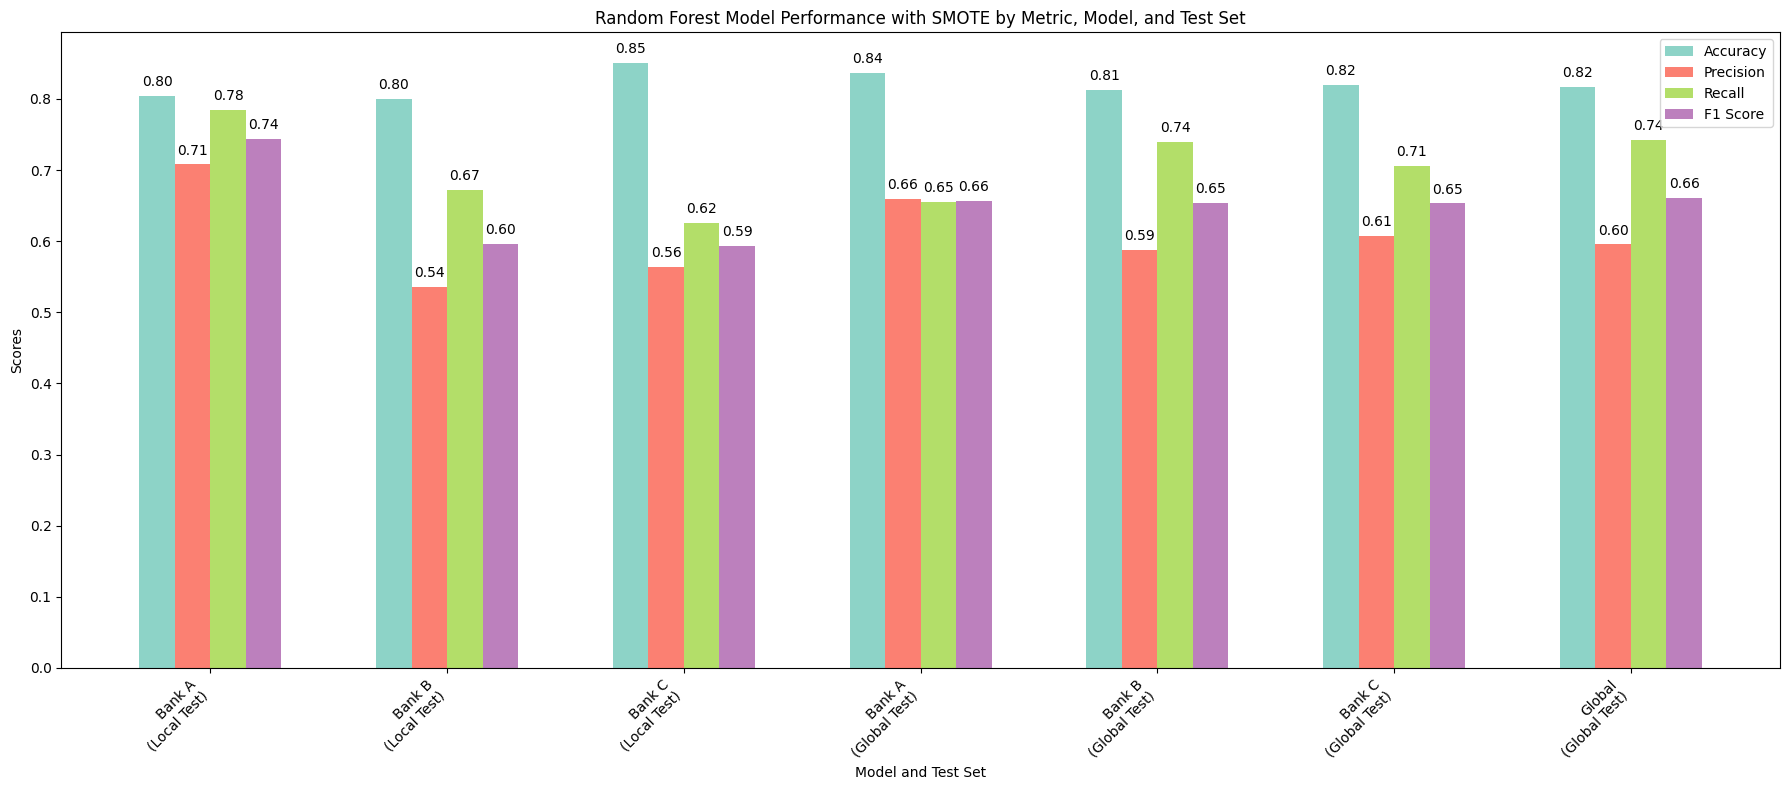

In [48]:
# Daten für den Plot vorbereiten
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
groups = ['Bank A\n(Local Test)', 'Bank B\n(Local Test)', 'Bank C\n(Local Test)', 
          'Bank A\n(Global Test)', 'Bank B\n(Global Test)', 'Bank C\n(Global Test)', 
          'Global\n(Global Test)']

values_rf_smote = np.array([
    [acc_rf_bank_a_smote, prec_rf_bank_a_smote, rec_rf_bank_a_smote, f1_rf_bank_a_smote],
    [acc_rf_bank_b_smote, prec_rf_bank_b_smote, rec_rf_bank_b_smote, f1_rf_bank_b_smote],
    [acc_rf_bank_c_smote, prec_rf_bank_c_smote, rec_rf_bank_c_smote, f1_rf_bank_c_smote],
    [acc_rf_bank_a_global_smote, prec_rf_bank_a_global_smote, rec_rf_bank_a_global_smote, f1_rf_bank_a_global_smote],
    [acc_rf_bank_b_global_smote, prec_rf_bank_b_global_smote, rec_rf_bank_b_global_smote, f1_rf_bank_b_global_smote],
    [acc_rf_bank_c_global_smote, prec_rf_bank_c_global_smote, rec_rf_bank_c_global_smote, f1_rf_bank_c_global_smote],
    [acc_rf_global_smote, prec_rf_global_smote, rec_rf_global_smote, f1_rf_global_smote]
])

n_groups = len(groups)
n_metrics = len(metrics)
index = np.arange(n_groups)  # Die Gruppen-Positionen auf der x-Achse
bar_width = 0.15  # Die Breite der Balken

fig, ax = plt.subplots(figsize=(18, 8))

# Erstelle Balken für jede Metrik
for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, values_rf_smote[:, i], bar_width, label=metric, color=plt.cm.Set3(i / float(n_metrics)))

# Hinzufügen von Text für Labels, Titel und benutzerdefinierte x-Achsen-Tick-Labels usw.
ax.set_xlabel('Model and Test Set')
ax.set_ylabel('Scores')
ax.set_title('Random Forest Model Performance with SMOTE by Metric, Model, and Test Set')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

# Hinzufügen von Werte-Labels über jedem Balken
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        ax.annotate(
            '{:.2f}'.format(y_value), 
            (x_value, y_value), 
            xytext=(0, space), 
            textcoords='offset points', 
            ha='center', 
            va=va)

add_value_labels(ax)

plt.tight_layout()
plt.show()

In [49]:
print(values_rf_base)
print(values_rf_smote)

[[0.80106101 0.7214886  0.73382173 0.72760291]
 [0.83015125 0.64       0.52252252 0.57532548]
 [0.86987104 0.64453125 0.55743243 0.59782609]
 [0.834      0.66647951 0.61790734 0.64127499]
 [0.835      0.68245294 0.58511192 0.63004484]
 [0.83575    0.68141064 0.59344092 0.63439065]
 [0.8295     0.66107577 0.5950026  0.62630137]]
[[0.8045977  0.707828   0.78388278 0.74391657]
 [0.79940491 0.53542601 0.6722973  0.59610584]
 [0.85111372 0.56402439 0.625      0.59294872]
 [0.835875   0.65932914 0.65486726 0.65709062]
 [0.8125     0.58701943 0.73919833 0.65437788]
 [0.82       0.60789592 0.70536179 0.65301205]
 [0.817      0.59532749 0.74284227 0.66095415]]


#### Random Forest - combined data - optimized with random search

In [50]:
# Definition des Hyperparameter-Suchraums
param_distributions = {
    'n_estimators': randint(100, 500),
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
    'max_features': ['sqrt', 'log2']
}

# Initialisierung des Random Forest-Modells für die Randomized Search
rf_random_search = RandomForestClassifier(random_state=42)

# Initialisierung von RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_random_search,
    param_distributions=param_distributions,
    n_iter=100,  # Anzahl der zu probierenden Parameterkombinationen
    cv=3,  # Anzahl der Cross-Validation-Folds
    verbose=2,
    random_state=42,
    n_jobs=-1  # Verwenden Sie alle verfügbaren Kerne
)

# Durchführung der Randomized Search auf den SMOTE-Daten
random_search.fit(X_train_global_smote, y_train_global_smote)

# Ausgabe der besten Parameter und des besten Scores
print("Beste Parameter:", random_search.best_params_)
print("Bester Score:", random_search.best_score_)

# Aktualisierung von optimal_rf_params mit den besten gefundenen Parametern
optimal_rf_params.update(random_search.best_params_)

# Entfernen des 'sampling_strategy' Parameters
if 'sampling_strategy' in optimal_rf_params:
    del optimal_rf_params['sampling_strategy']

# Training des Random Forest-Modells mit den aktualisierten optimalen Parametern
rf_global_optimized = RandomForestClassifier(**optimal_rf_params, random_state=42)
rf_global_optimized.fit(X_train_global_smote, y_train_global_smote)

# Bewertung des optimierten Modells
y_pred_rf_global_optimized = rf_global_optimized.predict(X_test_global)
acc_rf_global_optimized = accuracy_score(y_test_global, y_pred_rf_global_optimized)
prec_rf_global_optimized = precision_score(y_test_global, y_pred_rf_global_optimized, zero_division=0)
rec_rf_global_optimized = recall_score(y_test_global, y_pred_rf_global_optimized)
f1_rf_global_optimized = f1_score(y_test_global, y_pred_rf_global_optimized)

print("Optimierte Modellleistung:")
print("Accuracy:", acc_rf_global_optimized)
print("Precision:", prec_rf_global_optimized)
print("Recall:", rec_rf_global_optimized)
print("F1-Score:", f1_rf_global_optimized)


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Beste Parameter: {'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 9, 'n_estimators': 180}
Bester Score: 0.8543211430795591
Optimierte Modellleistung:
Accuracy: 0.825125
Precision: 0.6054119547657512
Recall: 0.780322748568454
F1-Score: 0.6818285194450762


#### Random Forest - separate datasets - optimized with random search

In [51]:
#working on Bank A
rf_bank_a_random_search = RandomForestClassifier(random_state=42)

# Initialisierung von RandomizedSearchCV für Bank A
random_search_bank_a = RandomizedSearchCV(
    estimator=rf_bank_a_random_search,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Durchführung der Randomized Search auf den SMOTE-Daten für Bank A
random_search_bank_a.fit(X_train_bank_a_smote, y_train_bank_a_smote)

# Ausgabe der besten Parameter und des besten Scores für Bank A
print("Beste Parameter für Bank A:", random_search_bank_a.best_params_)
print("Bester Score für Bank A:", random_search_bank_a.best_score_)

# Training des Random Forest-Modells für Bank A mit den besten gefundenen Parametern
rf_bank_a_optimized = RandomForestClassifier(**random_search_bank_a.best_params_, random_state=42)
rf_bank_a_optimized.fit(X_train_bank_a_smote, y_train_bank_a_smote)

# Bewertung des optimierten Modells für Bank A auf dem lokalen Testset
y_pred_rf_bank_a_optimized_local = rf_bank_a_optimized.predict(X_test_bank_a)
acc_rf_bank_a_optimized_local = accuracy_score(y_test_bank_a, y_pred_rf_bank_a_optimized_local)
prec_rf_bank_a_optimized_local = precision_score(y_test_bank_a, y_pred_rf_bank_a_optimized_local, zero_division=0)
rec_rf_bank_a_optimized_local = recall_score(y_test_bank_a, y_pred_rf_bank_a_optimized_local)
f1_rf_bank_a_optimized_local = f1_score(y_test_bank_a, y_pred_rf_bank_a_optimized_local)

# Bewertung des optimierten Modells für Bank A auf dem globalen Testset
y_pred_rf_bank_a_optimized_global = rf_bank_a_optimized.predict(X_test_global)
acc_rf_bank_a_optimized_global = accuracy_score(y_test_global, y_pred_rf_bank_a_optimized_global)
prec_rf_bank_a_optimized_global = precision_score(y_test_global, y_pred_rf_bank_a_optimized_global, zero_division=0)
rec_rf_bank_a_optimized_global = recall_score(y_test_global, y_pred_rf_bank_a_optimized_global)
f1_rf_bank_a_optimized_global = f1_score(y_test_global, y_pred_rf_bank_a_optimized_global)

print("Optimierte Modellleistung für Bank A auf lokalem Testset:")
print("Accuracy:", acc_rf_bank_a_optimized_local)
print("Precision:", prec_rf_bank_a_optimized_local)
print("Recall:", rec_rf_bank_a_optimized_local)
print("F1-Score:", f1_rf_bank_a_optimized_local)

print("Optimierte Modellleistung für Bank A auf globalem Testset:")
print("Accuracy:", acc_rf_bank_a_optimized_global)
print("Precision:", prec_rf_bank_a_optimized_global)
print("Recall:", rec_rf_bank_a_optimized_global)
print("F1-Score:", f1_rf_bank_a_optimized_global)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Beste Parameter für Bank A: {'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 442}
Bester Score für Bank A: 0.8323724668064291
Optimierte Modellleistung für Bank A auf lokalem Testset:
Accuracy: 0.8178603006189213
Precision: 0.7248618784530386
Recall: 0.800976800976801
F1-Score: 0.7610208816705336
Optimierte Modellleistung für Bank A auf globalem Testset:
Accuracy: 0.84675
Precision: 0.6835710512414157
Recall: 0.6736074960957834
F1-Score: 0.6785527005768223


In [52]:
# working on Bank B
rf_bank_b_random_search = RandomForestClassifier(random_state=42)

# Initialisierung von RandomizedSearchCV für Bank B
random_search_bank_b = RandomizedSearchCV(
    estimator=rf_bank_b_random_search,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Durchführung der Randomized Search auf den SMOTE-Daten für Bank B
random_search_bank_b.fit(X_train_bank_b_smote, y_train_bank_b_smote)

# Ausgabe der besten Parameter und des besten Scores für Bank B
print("Beste Parameter für Bank B:", random_search_bank_b.best_params_)
print("Bester Score für Bank B:", random_search_bank_b.best_score_)

# Training des Random Forest-Modells für Bank B mit den besten gefundenen Parametern
rf_bank_b_optimized = RandomForestClassifier(**random_search_bank_b.best_params_, random_state=42)
rf_bank_b_optimized.fit(X_train_bank_b_smote, y_train_bank_b_smote)

# Bewertung des optimierten Modells für Bank C auf dem lokalen Testset
y_pred_rf_bank_b_optimized_local = rf_bank_b_optimized.predict(X_test_bank_b)
acc_rf_bank_b_optimized_local = accuracy_score(y_test_bank_b, y_pred_rf_bank_b_optimized_local)
prec_rf_bank_b_optimized_local = precision_score(y_test_bank_b, y_pred_rf_bank_b_optimized_local, zero_division=0)
rec_rf_bank_b_optimized_local = recall_score(y_test_bank_b, y_pred_rf_bank_b_optimized_local)
f1_rf_bank_b_optimized_local = f1_score(y_test_bank_b, y_pred_rf_bank_b_optimized_local)

# Bewertung des optimierten Modells für Bank C auf dem globalen Testset
y_pred_rf_bank_b_optimized_global = rf_bank_b_optimized.predict(X_test_global)
acc_rf_bank_b_optimized_global = accuracy_score(y_test_global, y_pred_rf_bank_b_optimized_global)
prec_rf_bank_b_optimized_global = precision_score(y_test_global, y_pred_rf_bank_b_optimized_global, zero_division=0)
rec_rf_bank_b_optimized_global = recall_score(y_test_global, y_pred_rf_bank_b_optimized_global)
f1_rf_bank_b_optimized_global = f1_score(y_test_global, y_pred_rf_bank_b_optimized_global)

print("Optimierte Modellleistung für Bank B auf lokalem Testset:")
print("Accuracy:", acc_rf_bank_b_optimized_local)
print("Precision:", prec_rf_bank_b_optimized_local)
print("Recall:", rec_rf_bank_b_optimized_local)
print("F1-Score:", f1_rf_bank_b_optimized_local)

print("Optimierte Modellleistung für Bank B auf globalem Testset:")
print("Accuracy:", acc_rf_bank_b_optimized_global)
print("Precision:", prec_rf_bank_b_optimized_global)
print("Recall:", rec_rf_bank_b_optimized_global)
print("F1-Score:", f1_rf_bank_b_optimized_global)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


Beste Parameter für Bank B: {'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 105}
Bester Score für Bank B: 0.8509974495912759
Optimierte Modellleistung für Bank B auf lokalem Testset:
Accuracy: 0.8060996776593107
Precision: 0.5440199335548173
Recall: 0.7376126126126126
F1-Score: 0.6261950286806883
Optimierte Modellleistung für Bank B auf globalem Testset:
Accuracy: 0.812875
Precision: 0.5815384615384616
Recall: 0.7870900572618428
F1-Score: 0.6688785666887858


In [53]:
# working on Bank C
rf_bank_c_random_search = RandomForestClassifier(random_state=42)

# Initialisierung von RandomizedSearchCV für Bank C
random_search_bank_c = RandomizedSearchCV(
    estimator=rf_bank_c_random_search,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Durchführung der Randomized Search auf den SMOTE-Daten für Bank C
random_search_bank_c.fit(X_train_bank_c_smote, y_train_bank_c_smote)

# Ausgabe der besten Parameter und des besten Scores für Bank C
print("Beste Parameter für Bank C:", random_search_bank_c.best_params_)
print("Bester Score für Bank C:", random_search_bank_c.best_score_)

# Training des Random Forest-Modells für Bank C mit den besten gefundenen Parametern
rf_bank_c_optimized = RandomForestClassifier(**random_search_bank_c.best_params_, random_state=42)
rf_bank_c_optimized.fit(X_train_bank_c_smote, y_train_bank_c_smote)

# Bewertung des optimierten Modells für Bank C auf dem lokalen Testset
y_pred_rf_bank_c_optimized_local = rf_bank_c_optimized.predict(X_test_bank_c)
acc_rf_bank_c_optimized_local = accuracy_score(y_test_bank_c, y_pred_rf_bank_c_optimized_local)
prec_rf_bank_c_optimized_local = precision_score(y_test_bank_c, y_pred_rf_bank_c_optimized_local, zero_division=0)
rec_rf_bank_c_optimized_local = recall_score(y_test_bank_c, y_pred_rf_bank_c_optimized_local)
f1_rf_bank_c_optimized_local = f1_score(y_test_bank_c, y_pred_rf_bank_c_optimized_local)

# Bewertung des optimierten Modells für Bank C auf dem globalen Testset
y_pred_rf_bank_c_optimized_global = rf_bank_c_optimized.predict(X_test_global)
acc_rf_bank_c_optimized_global = accuracy_score(y_test_global, y_pred_rf_bank_c_optimized_global)
prec_rf_bank_c_optimized_global = precision_score(y_test_global, y_pred_rf_bank_c_optimized_global, zero_division=0)
rec_rf_bank_c_optimized_global = recall_score(y_test_global, y_pred_rf_bank_c_optimized_global)
f1_rf_bank_c_optimized_global = f1_score(y_test_global, y_pred_rf_bank_c_optimized_global)

print("Optimierte Modellleistung für Bank C auf lokalem Testset:")
print("Accuracy:", acc_rf_bank_c_optimized_local)
print("Precision:", prec_rf_bank_c_optimized_local)
print("Recall:", rec_rf_bank_c_optimized_local)
print("F1-Score:", f1_rf_bank_c_optimized_local)

print("Optimierte Modellleistung für Bank C auf globalem Testset:")
print("Accuracy:", acc_rf_bank_c_optimized_global)
print("Precision:", prec_rf_bank_c_optimized_global)
print("Recall:", rec_rf_bank_c_optimized_global)
print("F1-Score:", f1_rf_bank_c_optimized_global)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Beste Parameter für Bank C: {'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 105}
Bester Score für Bank C: 0.896030968738828
Optimierte Modellleistung für Bank C auf lokalem Testset:
Accuracy: 0.8552168815943728
Precision: 0.5706051873198847
Recall: 0.668918918918919
F1-Score: 0.6158631415241057
Optimierte Modellleistung für Bank C auf globalem Testset:
Accuracy: 0.819625
Precision: 0.6000837520938024
Recall: 0.7459656428943259
F1-Score: 0.6651195172893943


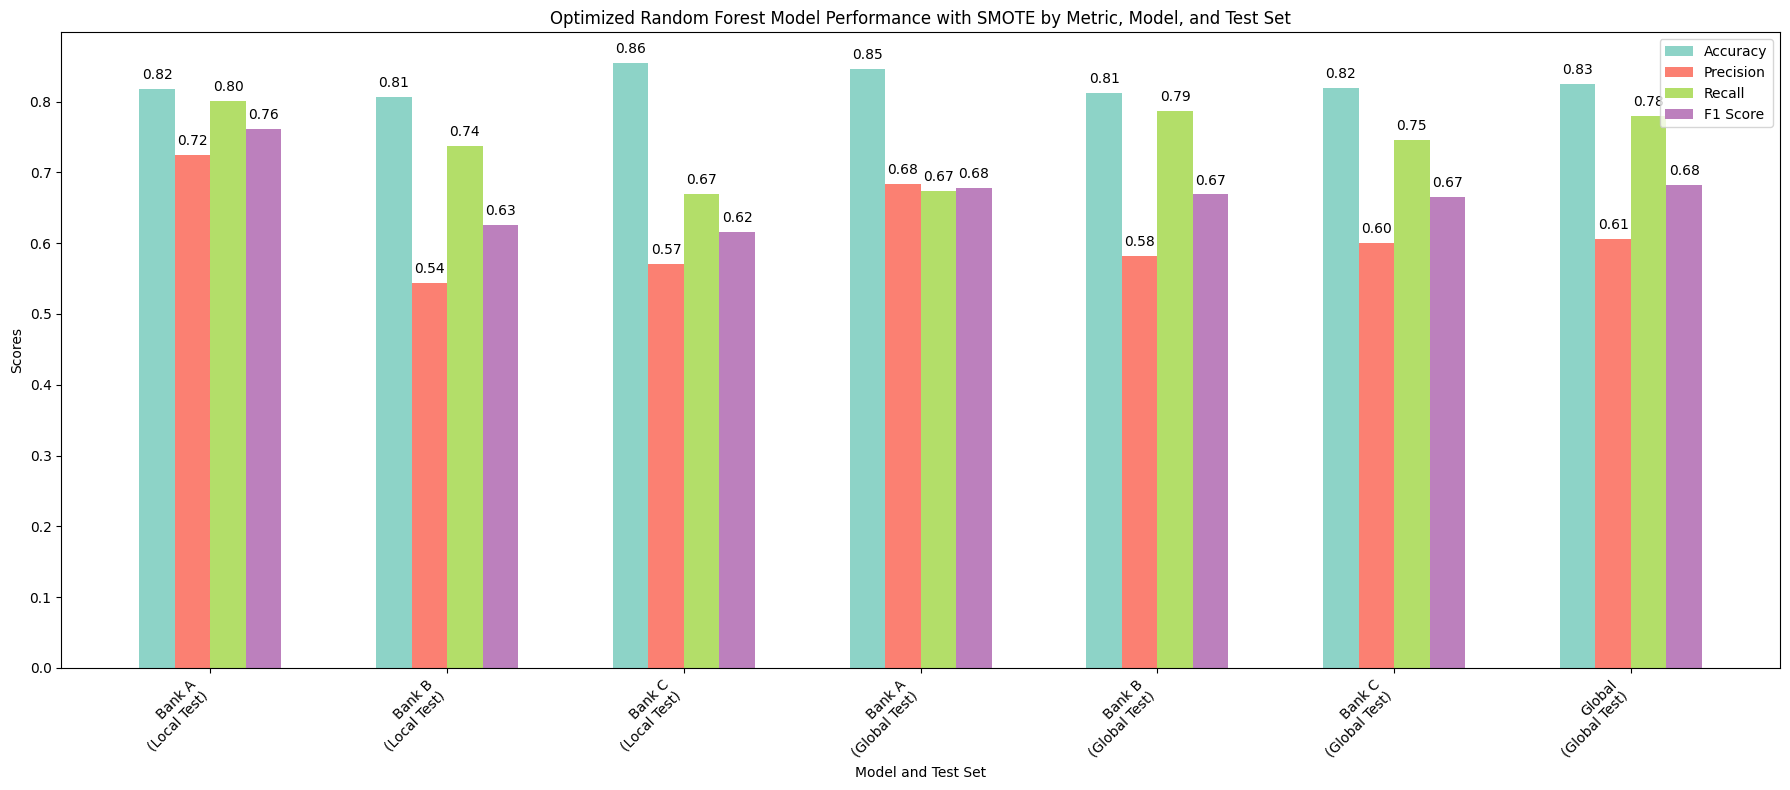

In [54]:
# Daten für den Plot vorbereiten
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
groups = ['Bank A\n(Local Test)', 'Bank B\n(Local Test)', 'Bank C\n(Local Test)', 
          'Bank A\n(Global Test)', 'Bank B\n(Global Test)', 'Bank C\n(Global Test)', 
          'Global\n(Global Test)']

# Ersetzen Sie die folgenden Variablen durch Ihre tatsächlichen Ergebnisse
values_rf_optimized_smote = np.array([
    [acc_rf_bank_a_optimized_local, prec_rf_bank_a_optimized_local, rec_rf_bank_a_optimized_local, f1_rf_bank_a_optimized_local],
    [acc_rf_bank_b_optimized_local, prec_rf_bank_b_optimized_local, rec_rf_bank_b_optimized_local, f1_rf_bank_b_optimized_local],
    [acc_rf_bank_c_optimized_local, prec_rf_bank_c_optimized_local, rec_rf_bank_c_optimized_local, f1_rf_bank_c_optimized_local],
    [acc_rf_bank_a_optimized_global, prec_rf_bank_a_optimized_global, rec_rf_bank_a_optimized_global, f1_rf_bank_a_optimized_global],
    [acc_rf_bank_b_optimized_global, prec_rf_bank_b_optimized_global, rec_rf_bank_b_optimized_global, f1_rf_bank_b_optimized_global],
    [acc_rf_bank_c_optimized_global, prec_rf_bank_c_optimized_global, rec_rf_bank_c_optimized_global, f1_rf_bank_c_optimized_global],
    [acc_rf_global_optimized, prec_rf_global_optimized, rec_rf_global_optimized, f1_rf_global_optimized]
])

n_groups = len(groups)
n_metrics = len(metrics)
index = np.arange(n_groups)  # Die Gruppen-Positionen auf der x-Achse
bar_width = 0.15  # Die Breite der Balken

fig, ax = plt.subplots(figsize=(18, 8))

# Erstelle Balken für jede Metrik
for i, metric in enumerate(metrics):
    ax.bar(index + i * bar_width, values_rf_optimized_smote[:, i], bar_width, label=metric, color=plt.cm.Set3(i / float(n_metrics)))

# Hinzufügen von Text für Labels, Titel und benutzerdefinierte x-Achsen-Tick-Labels usw.
ax.set_xlabel('Model and Test Set')
ax.set_ylabel('Scores')
ax.set_title('Optimized Random Forest Model Performance with SMOTE by Metric, Model, and Test Set')
ax.set_xticks(index + 1.5 * bar_width)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

# Hinzufügen von Werte-Labels über jedem Balken
def add_value_labels(ax, spacing=5):
    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2
        space = spacing
        va = 'bottom'
        if y_value < 0:
            space *= -1
            va = 'top'
        ax.annotate(
            '{:.2f}'.format(y_value), 
            (x_value, y_value), 
            xytext=(0, space), 
            textcoords='offset points', 
            ha='center', 
            va=va)

add_value_labels(ax)

plt.tight_layout()
plt.show()


In [55]:
print(values_rf_optimized_smote)

[[0.8178603  0.72486188 0.8009768  0.76102088]
 [0.80609968 0.54401993 0.73761261 0.62619503]
 [0.85521688 0.57060519 0.66891892 0.61586314]
 [0.84675    0.68357105 0.6736075  0.6785527 ]
 [0.812875   0.58153846 0.78709006 0.66887857]
 [0.819625   0.60008375 0.74596564 0.66511952]
 [0.825125   0.60541195 0.78032275 0.68182852]]


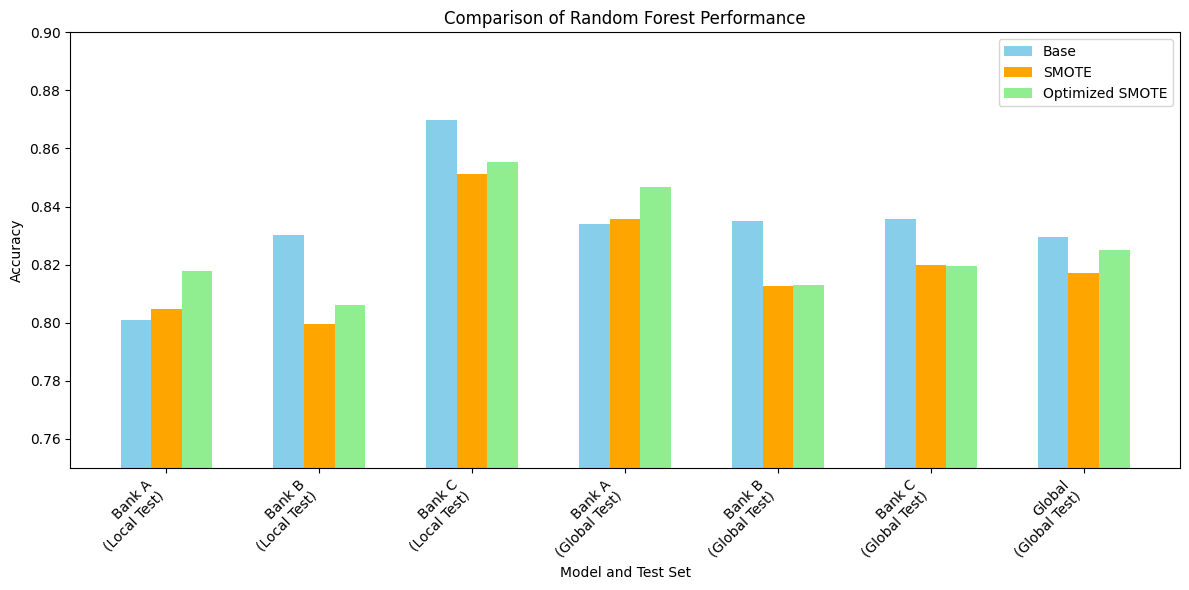

In [56]:
# Definition der Gruppen für den Plot
groups = [
    'Bank A\n(Local Test)', 'Bank B\n(Local Test)', 'Bank C\n(Local Test)',
    'Bank A\n(Global Test)', 'Bank B\n(Global Test)', 'Bank C\n(Global Test)',
    'Global\n(Global Test)'
]

# Extraktion der Genauigkeitswerte aus den Arrays
accuracy_base = [values_rf_base[i][0] for i in range(len(groups))]
accuracy_smote = [values_rf_smote[i][0] for i in range(len(groups))]
accuracy_optimized_smote = [values_rf_optimized_smote[i][0] for i in range(len(groups))]

# Erstellung des Plots
fig, ax = plt.subplots(figsize=(12, 6))

# Positionen der Gruppen auf der X-Achse und Breite der Balken
index = np.arange(len(groups))
bar_width = 0.2

# Balken für jede Genauigkeitsgruppe
ax.bar(index, accuracy_base, bar_width, label='Base', color='skyblue')
ax.bar(index + bar_width, accuracy_smote, bar_width, label='SMOTE', color='orange')
ax.bar(index + 2*bar_width, accuracy_optimized_smote, bar_width, label='Optimized SMOTE', color='lightgreen')

# Hinzufügen von Beschriftungen, Titel, Legende und Anpassung der X-Achsen-Ticks
ax.set_xlabel('Model and Test Set')
ax.set_ylabel('Accuracy')
ax.set_title('Comparison of Random Forest Performance')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(groups, rotation=45, ha='right')
ax.legend()

# Anzeigen des Plots
plt.ylim(0.75, 0.9) 
plt.tight_layout()
plt.show()


##### Base vs. SMOTE vs. Optimized SMOTE
Base: The base values generally show good performance, with high accuracy across all models, but there's room for improvement in detecting the minority class, as indicated by the lower Recall values.

SMOTE:
After applying SMOTE to balance the classes, we generally see an improvement in Recall, suggesting that the models are better at recognizing the minority class. However, this comes at the cost of Precision, especially in local tests for Banks A and B, indicating an increase in false positive results.

Optimized SMOTE:
After optimizing hyperparameters with Random Search, we see mixed results. While some metrics improved, like Recall in most cases and Precision in some, there are also areas where performance decreased, especially Precision in local tests. It shows that hyperparameter optimization improved the models' ability to make correct predictions in some cases, but it may have also led to overfitting to specific features of the training data, affecting generalizability.

##### Interpretation
Minority Class Detection:
SMOTE has generally helped improve the detection of the minority class (individuals earning >50K), as shown by the increased Recall values. This is a positive outcome, as it suggests that after applying SMOTE, models are less likely to wrongly classify individuals from the minority class as belonging to the majority class.

Precision vs. Recall:
The optimization led to a trade-off between Precision and Recall in some cases. While Recall improved in many cases, indicating better detection of the minority class, Precision decreased in some instances. This suggests that the models might be too aggressive in classifying observations as belonging to the minority class, leading to an increased number of false positives.

Performance Across Different Test Sets:
The models show different performances on local and global test sets. This might be due to differences in data distributions between the banks and the global dataset. Optimizations based on a specific dataset might not be directly transferable to other datasets, highlighting the importance of careful validation and generalizability testing.

##### Conclusion
Hyperparameter optimization led to improvements in some cases, especially in detecting the minority class, as evidenced by increased Recall values. However, there are also areas where performance decreased, especially Precision in some local tests. 